# Medical Image Segmentation with U-Net in PyTorch

This notebook provides a step-by-step guide to performing medical image segmentation using a U-Net architecture in PyTorch. It is adapted for publicly available medical imaging datasets. Here, we assume using the MSD (Medical Segmentation Decathlon) Brain Tumor data as an example, but the instructions are general enough to apply to other datasets like LUNA16.


## Step 1: Environment Setup
Install required dependencies if needed (Colab already has many of these):
- **Python 3.7+**
- **PyTorch**
- **NumPy** and **scikit-image** (or **SimpleITK**) for image I/O and preprocessing
- **Matplotlib**, **graphviz**, and **torchviz** for visualization
- **tqdm** for progress bars during training
- **nibabel** used for reading, writing, and processing neuroimaging file formats, such as NIfTI, MINC, and Analyze

In [1]:
!pip install torch matplotlib tqdm scikit-image nibabel graphviz torchviz

## Step 2: Downloading and Understanding the Dataset
---
### 1. Types of Tumors and Pathologies in the MSD Datasets

The MSD contains multiple tasks, each focusing on segmenting a particular organ or pathological structure. Here are some brief examples to illustrate the variety of pathologies:

- **Brain Tumor (Task01_BrainTumour)**  
  - **Types of Brain Tumors**: Common types include gliomas (which can be subdivided into astrocytomas, oligodendrogliomas, and glioblastomas), meningiomas, and pituitary adenomas, among others. Many brain tumor segmentation challenges focus specifically on high-grade gliomas (e.g., Glioblastoma Multiforme) and low-grade gliomas.  
  - **Pathological Structures**: The provided labels typically delineate regions such as the enhancing tumor core, necrotic or non-enhancing core, and edema (swelling around the tumor).

- **Heart (Task02_Heart)**  
  - **Primary Focus**: Segmentation of cardiac structures such as the left ventricle and its myocardium in MRI scans. This is crucial for measuring ejection fraction and assessing heart function.

- **Liver (Task03_Liver)**  
  - **Pathologies**: Liver lesions (e.g., hepatocellular carcinoma). Proper liver lesion segmentation helps in treatment planning, especially for resections.

- **Other Examples (Hippocampus, Prostate, Lung, Pancreas, Hepatic Vessel, Spleen, Colon)**  
  - These tasks cover either the entire organ (e.g., spleen, colon) or specific lesions/tumors within them (e.g., prostate cancer, pancreatic masses, lung nodules).  
  - In the Hippocampus dataset, for instance, the structures within the hippocampal formation may be segmented to study neurological conditions such as Alzheimer’s.

---

### 2. Focusing on the Brain Tumor Case

- **Modality**: Multi-modal MRI scans, commonly including T1-weighted, T2-weighted, T1-weighted contrast-enhanced, and FLAIR (Fluid Attenuated Inversion Recovery) images. Each modality provides unique contrast characteristics that help distinguish tumor tissues from healthy tissues.  
   1. **T1-weighted (T1W)**  
      - T1 (Longitudinal Relaxation Time): The time it takes for protons to realign with the magnetic field after excitation.
      - Provides high anatomical detail.  
      - Cerebrospinal fluid (CSF) appears **dark**, while fat appears **bright**.

   2. **T2-weighted (T2W)**  
      - T2 (Transverse Relaxation Time): The time it takes for proton spins to lose phase coherence after excitation.
      - Highlights fluid-containing structures.  
      - CSF appears **bright**, useful for detecting **edema and pathology**.

   3. **T1-weighted Contrast-Enhanced (T1W+CE)**  
      - Uses contrast agent (e.g., gadolinium).  
      - Enhances **vascular structures and lesions**.

   4. **FLAIR (Fluid-Attenuated Inversion Recovery)**  
      - Similar to T2 but **suppresses CSF signals**.  
      - Improves visibility of **periventricular lesions (e.g., multiple sclerosis)**.
   
- **Segmentation Masks**:  
  - **Enhancing Tumor**: The part of the tumor that “lights up” with contrast, indicating a disruption in the blood-brain barrier.  
  - **Non-Enhancing/Core Region**: The necrotic or non-enhancing tissue within the tumor.  
  - **Edema**: Swollen tissue around the tumor.  
- **Clinical Relevance**: Accurate segmentation enables doctors and researchers to measure tumor size, track disease progression, and plan interventions or surgeries.

---

### 3. NIfTI File Format in Medical Imaging

1. **What is NIfTI?**  
   - **NIfTI** (Neuroimaging Informatics Technology Initiative) is a popular file format (usually `.nii` or `.nii.gz`) for storing medical imaging data, particularly in neuroimaging.  
   - **Structure**: NIfTI files typically contain both the imaging data and associated metadata (e.g., voxel dimensions, orientation) in a single file.

2. **Why are medical images provided in this format?**  
   - **Standardization**: NIfTI is well-established in research, especially for MRI and other 3D/4D medical images, allowing for data exchange across different tools.  
   - **Metadata integration**: It contains a header that describes how to interpret the voxel data (dimensions, spacing, orientation, etc.).  
   - **Compression**: Often distributed as `.nii.gz`, providing smaller file sizes without losing information. 
   - **Widespread Support**: Tools like `nibabel`, `SimpleITK` can easily read and write NIfTI files of 3D/4D data in Python or other environments..  

3. **Other common medical imaging formats**  
   - **DICOM (Digital Imaging and Communications in Medicine)**: A widely used clinical standard with one file per “slice” and associated metadata.  
   - **MHA / MHD (MetaImage)**: Another medical image format that keeps data (`.raw` or `.zraw`) and metadata (`.mhd`) in separate files.  
---

### 4. Organizing and Preparing the Dataset

1. **Download**:  
   - You would typically download from [http://medicaldecathlon.com](http://medicaldecathlon.com). For our focus: `Task01_BrainTumour`.

2. **Structure**:  
   - You will often see subfolders like `imagesTr` and `labelsTr` (for training) and `imagesTs` and `labelsTs` (for testing).  
   - Each subject can have a `.nii.gz` file for different MRI modalities, plus one segmentation mask.

3. **Reading and Processing**:  
   - **Python Tools**: `nibabel` can read the `.nii.gz` files, providing NumPy arrays.  
   - **Data Dimensions**: Remember that these scans are 3D volumes. You may slice them in 2D or process them fully in 3D.
      - **2D Approach**: Treat each slice of the 3D volume as an independent 2D image.  
      - **3D Approach**: More computationally demanding but uses the spatial context across slices, often leading to better segmentation performance.

In [1]:
import os

target_dir = '/home/tourist/CSYE7374-Healthcare/data/'

# Check if the tar file exists
if not os.path.exists('/home/tourist/CSYE7374-Healthcare/data/Task01_BrainTumour.tar'):
    print("Dataset not found locally, downloading now...")
    # !wget -q https://msd-for-monai.s3-us-west-2.amazonaws.com/Task01_BrainTumour.tar -O Task01_BrainTumour.tar # silently downloads a .tar archive containing the Brain Tumour dataset.
    print("Download complete!")
else:
    print("Dataset archive already exists, skipping download.")



# Extract the dataset
if not os.path.exists(os.path.join(target_dir, 'Task01_BrainTumour')):
    print("Extracting the dataset...")
    !tar -xf /home/tourist/CSYE7374-Healthcare/data/Task01_BrainTumour.tar -C {target_dir}
    print("Extraction complete!")
else:
    print("Dataset folder already exists, skipping extraction.")

print("Verifying the contents of the Task01_BrainTumour directory:")
!ls /home/tourist/CSYE7374-Healthcare/data/Task01_BrainTumour # displays the files or subfolders inside that directory

# # Clean up the tar file
# !rm Task01_BrainTumour.tar
# print("Cleaned up the tar file after extraction!")

# Install and use tree to visualize directory structure
# !brew install tree
!tree /home/tourist/CSYE7374-Healthcare/data/Task01_BrainTumour -L 2

Dataset archive already exists, skipping download.
Dataset folder already exists, skipping extraction.
Verifying the contents of the Task01_BrainTumour directory:
dataset.json  imagesTr	imagesTs  labelsTr
/home/tourist/CSYE7374-Healthcare/data/Task01_BrainTumour
├── dataset.json
├── imagesTr
│   ├── BRATS_001.nii.gz
│   ├── BRATS_002.nii.gz
│   ├── BRATS_003.nii.gz
│   ├── BRATS_004.nii.gz
│   ├── BRATS_005.nii.gz
│   ├── BRATS_006.nii.gz
│   ├── BRATS_007.nii.gz
│   ├── BRATS_008.nii.gz
│   ├── BRATS_009.nii.gz
│   ├── BRATS_010.nii.gz
│   ├── BRATS_011.nii.gz
│   ├── BRATS_012.nii.gz
│   ├── BRATS_013.nii.gz
│   ├── BRATS_014.nii.gz
│   ├── BRATS_015.nii.gz
│   ├── BRATS_016.nii.gz
│   ├── BRATS_017.nii.gz
│   ├── BRATS_018.nii.gz
│   ├── BRATS_019.nii.gz
│   ├── BRATS_020.nii.gz
│   ├── BRATS_021.nii.gz
│   ├── BRATS_022.nii.gz
│   ├── BRATS_023.nii.gz
│   ├── BRATS_024.nii.gz
│   ├── BRATS_025.nii.gz
│   ├── BRATS_026.nii.gz
│   ├── BRATS_027.nii.gz
│   ├── BRATS_028.nii.gz
│   ├──

## What does "BRATS" stand for?

**BRATS** (often stylized as **BraTS**) stands for **Brain Tumor Segmentation**. It refers to a series of **Brain Tumor Segmentation challenges**, which are highly influential in the medical image analysis community. These challenges typically focus on multi-modal MRI scans of brain tumors and provide labeled data for training segmentation models.

## Why is there no `labelsTs` folder?

In many medical imaging challenges (including some MSD tasks), **test set labels are kept hidden** by the organizers to ensure an unbiased evaluation process. Participants are usually asked to upload their predicted segmentations (based on `imagesTs`) to a competition platform (or follow the challenge guidelines). The organizers then compare the submitted predictions against the **unreleased** ground truth labels and publish the performance metrics. This approach prevents participants from overfitting to the test labels.

---

## Step 3: Data Inspection

1. **Explore Different MRI Modalities**  
   The BraTS dataset often includes multiple MRI sequences, such as T1-weighted (T1), T1-weighted with contrast enhancement (T1Gd), T2-weighted (T2), and FLAIR. Each modality provides unique contrast characteristics, enabling better visualization of tumor regions, surrounding edema, and healthy tissue. Inspecting each modality side by side helps illustrate how different MRI protocols highlight different anatomical or pathological features.

2. **Check Dimensions and Orientation**  
   BraTS volumes are 3D and may be captured in axial, sagittal, or coronal orientations depending on the scanning protocol. The voxel sizes can differ from patient to patient, so checking the dimensions (e.g., width, height, depth) and the orientation of each scan is important. This helps ensure a consistent preprocessing pipeline and avoids misalignment issues during segmentation.


3. **Inspect Intensity Histograms**  
   MRI intensity ranges can vary significantly due to scanner settings and patient differences. Generating histograms for each modality or channel helps identify potential outliers, noisy areas, or the presence of different tissue types. These observations guide normalization or standardization methods, ultimately improving segmentation quality.

[[<Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: >]]


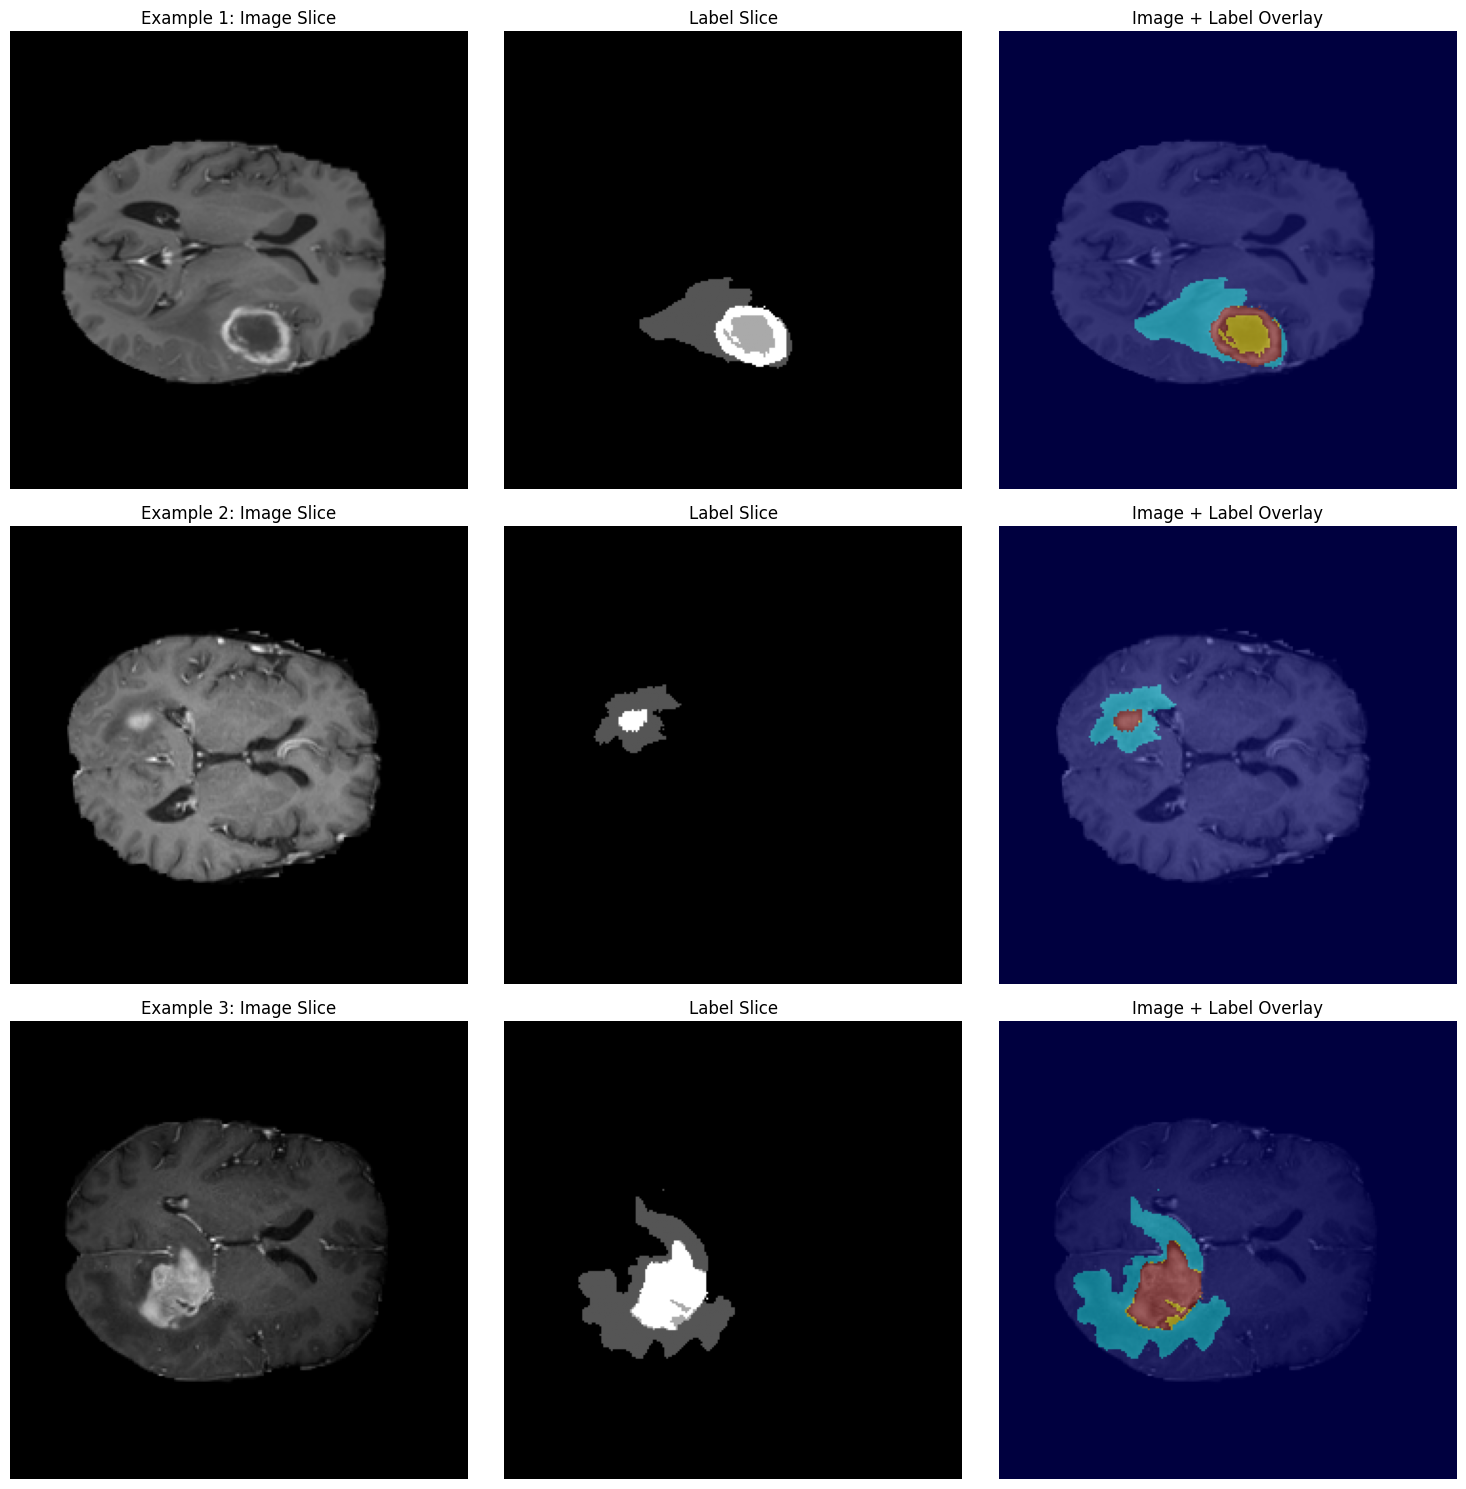

In [4]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

folder_path = "/home/tourist/CSYE7374-Healthcare/data/"

image_dir = folder_path + 'Task01_BrainTumour/imagesTr'
label_dir = folder_path + 'Task01_BrainTumour/labelsTr'

# Get list of images and labels
image_paths = sorted(glob.glob(os.path.join(image_dir, '*.nii.gz')))
label_paths = sorted(glob.glob(os.path.join(label_dir, '*.nii.gz')))

# We will visualize the first three examples
num_examples = 3

# Create a 3x3 grid: each row is an example, and each column is one of the views (image, label, overlay)
fig, axes = plt.subplots(num_examples, 3, figsize=(15, 15))
# print(axes)

# If num_examples is 1, axes won't be a 2D list. Ensure indexing works for both single and multiple examples
if num_examples == 1:
    axes = [axes]  # Make axes a list of lists for consistent indexing

# Choose a channel to display if you have multiple MRI modalities.
# For a multi-modal image, the shape might be (Height, Width, Depth, Channels).
channel_idx = 2

for i in range(num_examples):
    img_path = image_paths[i]
    lbl_path = label_paths[i]

    # Load the image and label volumes using nibabel
    image_nii = nib.load(img_path)
    label_nii = nib.load(lbl_path)

    # Convert nibabel objects to NumPy arrays
    image = image_nii.get_fdata()  # shape: (H, W, D) or (H, W, D, C) if multiple channels
    label = label_nii.get_fdata()  # shape: (H, W, D)

    # print(type(image), image.shape)
    # print(type(label), label.shape)


    # If image has multiple channels, pick the specified channel; otherwise, just use the array as is
    if image.ndim == 4:
        # Example shape: (H, W, D, Channels)
        # We'll pick a middle slice along the depth dimension for visualization
        slice_idx = image.shape[2] // 2
        img_slice = image[:, :, slice_idx, channel_idx]
        lbl_slice = label[:, :, slice_idx]
    else:
        # If there's only one channel, the shape might be (H, W, D)
        slice_idx = image.shape[2] // 2
        img_slice = image[:, :, slice_idx]
        lbl_slice = label[:, :, slice_idx]

    # Display the image slice
    axes[i][0].imshow(img_slice, cmap='gray')
    axes[i][0].set_title(f'Example {i+1}: Image Slice')
    axes[i][0].axis('off')

    # Display the label slice
    axes[i][1].imshow(lbl_slice, cmap='gray')
    axes[i][1].set_title('Label Slice')
    axes[i][1].axis('off')

    # Display an overlay of label on the image
    axes[i][2].imshow(img_slice, cmap='gray')
    axes[i][2].imshow(lbl_slice, cmap='jet', alpha=0.5)
    axes[i][2].set_title('Image + Label Overlay')
    axes[i][2].axis('off')

plt.tight_layout()
plt.show()


## Step 3: Data Preprocessing

**Key tasks:**
- **Normalization:** Medical images vary in intensity. Normalize voxel intensities to a standard range (e.g., zero mean, unit variance).
``(image - mean) / std``
- **Resampling / Resizing:** Different scans may have different resolutions. We need to resample all images to a consistent voxel spacing and/or resize slices for computational feasibility. ``scipy.ndimage.zoom``
- **Data Augmentation:** Introduce augmentations to improve generalization. Common augmentation:
    - Random flips (horizontal, vertical)
    - Random rotations
    - Intensity jitter (brightness/contrast shifts) - not for masks
        - **Brightness Shift:** The image intensity is uniformly increased or decreased by adding a random `delta` proportional to the image's mean intensity. This affects all pixels equally, making the image appear lighter or darker without changing relationships between pixel values.
        - **Contrast Shift:** The pixel values are scaled relative to the mean intensity by a factor `alpha`, making bright areas brighter and dark areas darker, enhancing or reducing contrast.


**Implementation:**
- For segmentations (masks), use nearest-neighbor interpolation when resizing so as not to introduce interpolation artifacts.
- For images, use linear interpolation when resizing to preserve image intensity continuity.
- Only apply intensity jitter to the image, not the segmentation.
- This code uses pure NumPy and SciPy functions. More sophisticated medical imaging pipelines (e.g., torchio, MONAI) that handle resampling and augmentations more elegantly can be used.

Selected random index: 414 out of 483


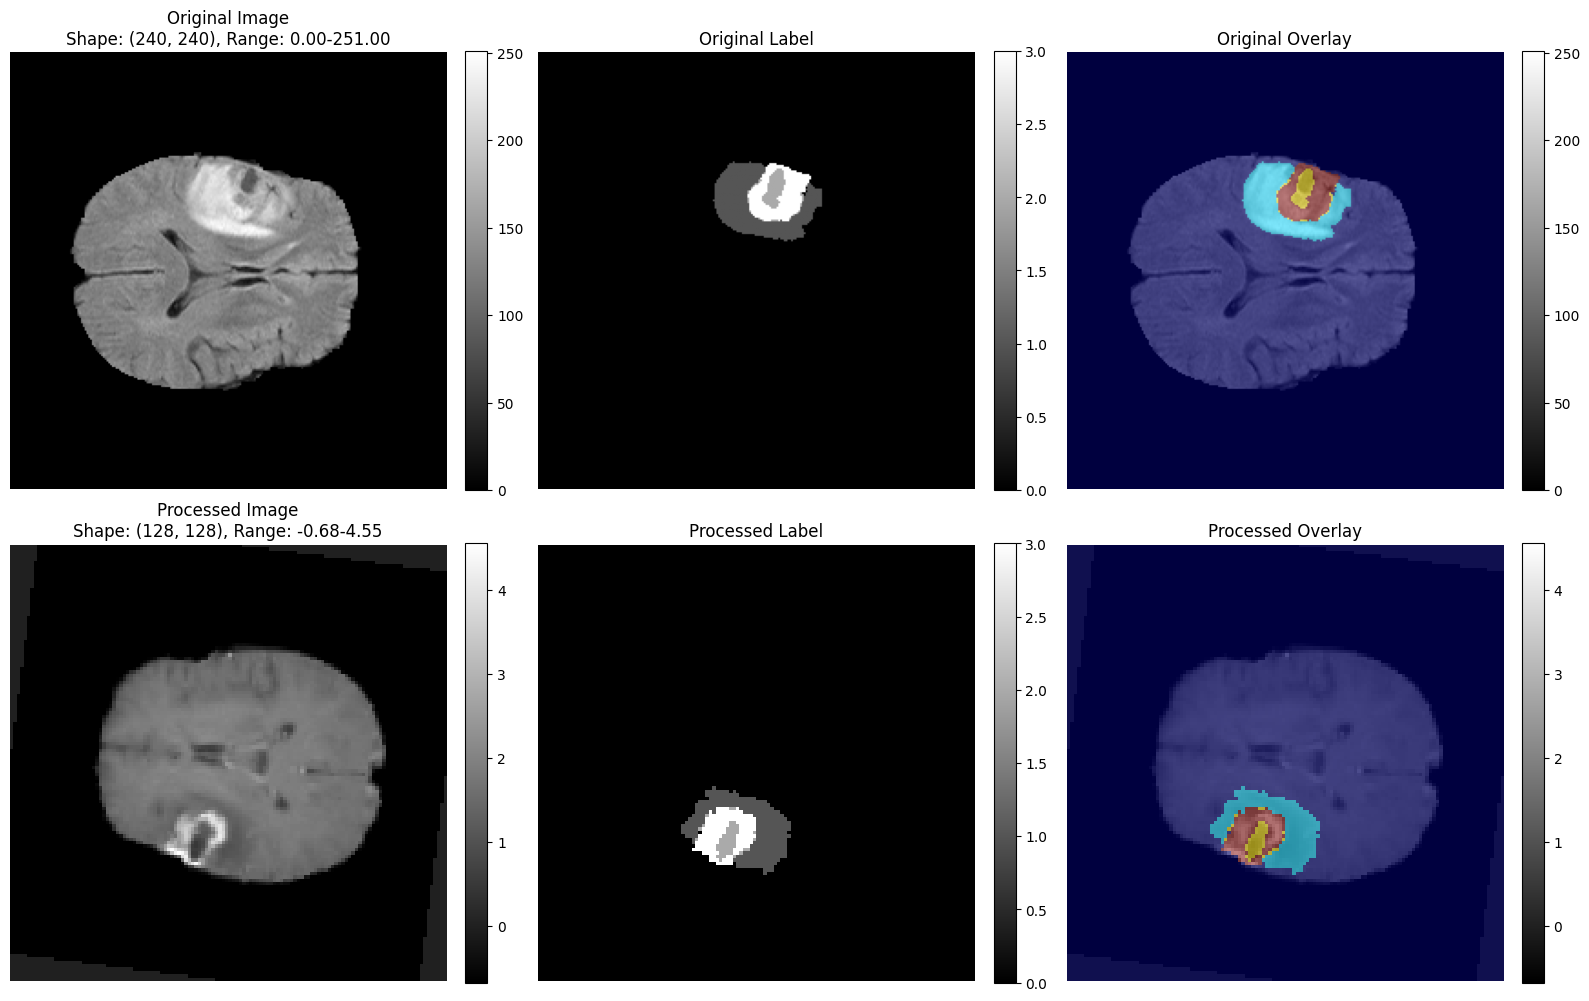

In [7]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import random
from scipy.ndimage import zoom, rotate

folder_path = "/home/tourist/CSYE7374-Healthcare/data/"

# Update these paths if necessary
image_dir = folder_path + 'Task01_BrainTumour/imagesTr'
label_dir = folder_path + 'Task01_BrainTumour/labelsTr'

image_paths = sorted(glob.glob(os.path.join(image_dir, '*.nii.gz')))
label_paths = sorted(glob.glob(os.path.join(label_dir, '*.nii.gz')))

def load_nifti(path):
    img = nib.load(path)
    data = img.get_fdata()
    return data

def normalize_volume(volume):
    mean = np.mean(volume)
    std = np.std(volume)
    return (volume - mean) / (std + 1e-8)

def resize_volume(image, target_shape, is_seg=False):
    """
    Resize 'image' to 'target_shape' using specified interpolation order:
      - order=1 for continuous data (MRI intensities)
      - order=0 for segmentation masks (nearest-neighbor)
    """
    current_shape = image.shape
    zoom_factors = [t / c for t, c in zip(target_shape, current_shape)]
    if is_seg:
        return zoom(image, zoom_factors, order=0)
    else:
        return zoom(image, zoom_factors, order=1)

def random_flip(image, seg):
    """ Randomly flip along 0th or 1st axis. """
    if random.random() < 0.5:
        image = np.flip(image, axis=1)
        seg = np.flip(seg, axis=1)
    if random.random() < 0.5:
        image = np.flip(image, axis=0)
        seg = np.flip(seg, axis=0)
    return image, seg

def random_rotate(image, seg, max_angle=5):
    """ Randomly rotate the image and label within 'max_angle' degrees. """
    angle = random.uniform(-max_angle, max_angle)
    image_rot = rotate(image, angle, axes=(0,1), reshape=False, order=1)
    seg_rot = rotate(seg, angle, axes=(0,1), reshape=False, order=0)
    return image_rot, seg_rot

def intensity_jitter(image, brightness_factor=0.1, contrast_factor=0.1):
    """ Randomly adjust brightness and contrast of the image. """
    # Random brightness shift
    delta = (random.random() * 2 - 1) * brightness_factor * np.mean(image)
    image = image + delta

    # Random contrast shift
    alpha = 1.0 + (random.random() * 2 - 1) * contrast_factor
    mean_val = np.mean(image)
    image = (image - mean_val) * alpha + mean_val
    return image

def preprocess_and_augment(image_path, seg_path, target_shape=None):
    image = load_nifti(image_path)
    seg = load_nifti(seg_path)

   # === Choose Slice ===
    depth = image.shape[-1] if image.ndim == 3 else image.shape[-2]
    slice_idx = depth // 2

    # If 4D (multi-channel), separate channel dimension from depth dimension
    if image.ndim == 4:  # (H, W, D, C)
        image_slice = image[:, :, slice_idx, :]
    else:  # (H, W, D)
        image_slice = image[:, :, slice_idx]

    mask_slice = seg[:, :, slice_idx]

    # ===  Normalize Image Slice ===
    # We typically don't normalize the mask (it contains discrete labels)
    if image_slice.ndim == 2:
        image_slice = normalize_volume(image_slice)
    else:
        # For multi-channel, normalize each channel separately
        for c in range(image_slice.shape[-1]):
            image_slice[..., c] = normalize_volume(image_slice[..., c])

    # === Resize (Optional) ===
    if target_shape is not None:
        if image_slice.ndim == 2:
            image_slice = resize_volume(image_slice, target_shape, is_seg=False)
            mask_slice = resize_volume(mask_slice, target_shape, is_seg=True)
        else:
            # Multi-channel image -> resize each channel
            h, w, c = image_slice.shape
            # e.g., target_shape = (128, 128) for 2D
            # resize each channel individually
            resized_channels = []
            for ch in range(c):
                resized_ch = resize_volume(image_slice[..., ch], target_shape, is_seg=False)
                resized_channels.append(resized_ch)
            # Stack back along channel dim
            image = np.stack(resized_channels, axis=-1)
            # Resize mask
            seg = resize_volume(mask_slice, target_shape, is_seg=True)

    # === Augmentations ===
    image, seg = random_flip(image, seg)
    image, seg = random_rotate(image, seg, max_angle=10)
    image = intensity_jitter(image, brightness_factor=0.1, contrast_factor=0.1)

    return image, seg

# Select one example at random for visualization
i = random.randint(0, len(image_paths) - 1)
print(f"Selected random index: {i} out of {len(image_paths) - 1}")

img_path = image_paths[i]
lbl_path = label_paths[i]

# Load original data (without augmentation/preprocessing)
image_nii = nib.load(img_path)
label_nii = nib.load(lbl_path)

image_original = image_nii.get_fdata()  # e.g. (H, W, D, C) or (H, W, D)
label_original = label_nii.get_fdata()

# For visualization, pick a channel and a slice
channel_idx = 0 if image_original.ndim == 4 else None
slice_idx = image_original.shape[2] // 2

if channel_idx is not None:
    img_slice_original = image_original[:, :, slice_idx, channel_idx]
else:
    img_slice_original = image_original[:, :, slice_idx]

lbl_slice_original = label_original[:, :, slice_idx]

# Now preprocess and augment the same data
target_shape = (128, 128)
image_processed, lbl_slice_processed  = preprocess_and_augment(
    img_path, lbl_path, target_shape=target_shape
)

# Choose a new slice index if shape has changed
slice_idx_processed = image_processed.shape[2] // 2
if len(image_processed.shape) == 4:
    img_slice_processed = image_processed[:, :, slice_idx_processed, channel_idx]
else:
    img_slice_processed = image_processed[:, :, slice_idx_processed]

# === Visualization: Before vs After ===
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# --- Original row ---
cax1 = axes[0][0].imshow(img_slice_original, cmap='gray')
axes[0][0].set_title(
    f'Original Image\nShape: {img_slice_original.shape}, '
    f'Range: {img_slice_original.min():.2f}-{img_slice_original.max():.2f}'
)
axes[0][0].axis('off')
# Add colorbar to show intensity range
plt.colorbar(cax1, ax=axes[0][0], fraction=0.046, pad=0.04)

cax2 = axes[0][1].imshow(lbl_slice_original, cmap='gray')
axes[0][1].set_title('Original Label')
axes[0][1].axis('off')
plt.colorbar(cax2, ax=axes[0][1], fraction=0.046, pad=0.04)

cax3 = axes[0][2].imshow(img_slice_original, cmap='gray')
axes[0][2].imshow(lbl_slice_original, cmap='jet', alpha=0.5)
axes[0][2].set_title('Original Overlay')
axes[0][2].axis('off')
# For the overlay, just show the colorbar for the grayscale image
plt.colorbar(cax3, ax=axes[0][2], fraction=0.046, pad=0.04)

# --- Processed row ---
cax4 = axes[1][0].imshow(img_slice_processed, cmap='gray')
axes[1][0].set_title(
    f'Processed Image\nShape: {img_slice_processed.shape}, '
    f'Range: {img_slice_processed.min():.2f}-{img_slice_processed.max():.2f}'
)
axes[1][0].axis('off')
plt.colorbar(cax4, ax=axes[1][0], fraction=0.046, pad=0.04)

cax5 = axes[1][1].imshow(lbl_slice_processed, cmap='gray')
axes[1][1].set_title('Processed Label')
axes[1][1].axis('off')
plt.colorbar(cax5, ax=axes[1][1], fraction=0.046, pad=0.04)

cax6 = axes[1][2].imshow(img_slice_processed, cmap='gray')
axes[1][2].imshow(lbl_slice_processed, cmap='jet', alpha=0.5)
axes[1][2].set_title('Processed Overlay')
axes[1][2].axis('off')
plt.colorbar(cax6, ax=axes[1][2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Step 4: Custom PyTorch Dataset
We'll create a dataset class that:

- Loads NIfTI images
- Extracts a 2D slice
- Normalizes and augments the images (random flip, rotation, intensity jitter, etc.)

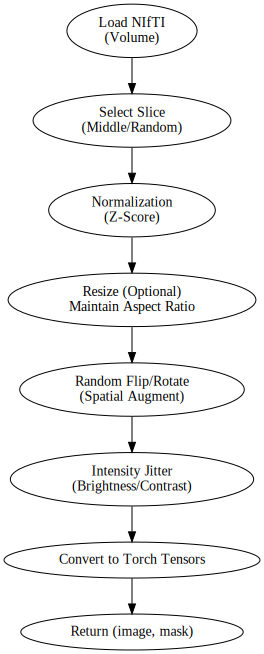

Batch 0 - Images shape: torch.Size([20, 4, 256, 256]), Masks shape: torch.Size([20, 1, 256, 256])


In [8]:
import os
import random
import glob
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from scipy.ndimage import zoom, rotate
from graphviz import Digraph


def load_nifti(path: str) -> np.ndarray:
    """
    Loads a NIfTI (.nii, .nii.gz) file from the given path and returns a NumPy array.
    """
    nifti_obj = nib.load(path)
    return nifti_obj.get_fdata()


def normalize_volume(volume: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """
    Z-score normalization of a 3D (or 2D) volume.

    Args:
        volume (np.ndarray): Input image volume.
        eps (float): Small constant to avoid division by zero.
    Returns:
        np.ndarray: Normalized volume with mean ~ 0 and std ~ 1.
    """
    mean = np.mean(volume)
    std = np.std(volume)
    return (volume - mean) / (std + eps)


def resize_volume(image: np.ndarray, target_shape: tuple, is_seg: bool = False) -> np.ndarray:
    """
    Resizes a 3D volume (or 2D slice) to target_shape using different interpolation orders:
      - order=1 for image intensities
      - order=0 for segmentation masks (nearest neighbor)

    Args:
        image (np.ndarray): Input volume (H, W, D) or (H, W).
        target_shape (tuple): Desired output shape (H_new, W_new, D_new) or (H_new, W_new).
        is_seg (bool): Whether the volume is a segmentation mask.

    Returns:
        np.ndarray: Resized volume.
    """
    current_shape = image.shape
    zoom_factors = [t / c for t, c in zip(target_shape, current_shape)]
    order = 0 if is_seg else 1  # nearest-neighbor for masks, linear for images
    return zoom(image, zoom_factors, order=order)


def random_flip(image: np.ndarray, seg: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Randomly flips the input image & segmentation mask horizontally or vertically with 50% chance each.

    Args:
        image (np.ndarray): 2D or 3D image volume.
        seg (np.ndarray): Corresponding segmentation volume.
    Returns:
        (image, seg): Flipped image & mask.
    """
    # Horizontal flip
    if random.random() < 0.5:
        image = np.flip(image, axis=1)
        seg = np.flip(seg, axis=1)

    # Vertical flip
    if random.random() < 0.5:
        image = np.flip(image, axis=0)
        seg = np.flip(seg, axis=0)
    return image, seg


def random_rotate(image: np.ndarray, seg: np.ndarray, max_angle: float = 10) -> (np.ndarray, np.ndarray):
    """
    Randomly rotates the image & segmentation mask within the range [-max_angle, max_angle] degrees.
    Uses order=1 for images and order=0 for masks to preserve label integrity.

    Args:
        image (np.ndarray): 2D or 3D image volume.
        seg (np.ndarray): Corresponding segmentation volume.
        max_angle (float): Maximum rotation angle in degrees.

    Returns:
        (image_rot, seg_rot): Rotated image & mask.
    """
    angle = random.uniform(-max_angle, max_angle)
    image_rot = rotate(image, angle, axes=(0,1), reshape=False, order=1)
    seg_rot = rotate(seg, angle, axes=(0,1), reshape=False, order=0)
    return image_rot, seg_rot


def intensity_jitter(image: np.ndarray, brightness_factor: float = 0.1, contrast_factor: float = 0.1) -> np.ndarray:
    """
    Randomly adjusts brightness and contrast of the image.

    Args:
        image (np.ndarray): Input image volume (2D or 3D).
        brightness_factor (float): Scale of random brightness change.
        contrast_factor (float): Scale of random contrast change.

    Returns:
        np.ndarray: Image with adjusted brightness/contrast.
    """
    # Brightness shift
    delta = (random.random() * 2 - 1) * brightness_factor * np.mean(image)
    image = image + delta

    # Contrast change
    alpha = 1.0 + (random.random() * 2 - 1) * contrast_factor
    mean_val = np.mean(image)
    image = (image - mean_val) * alpha + mean_val
    return image


def visualize_pipeline_graph():
    """
    Optionally visualizes the data loading pipeline using graphviz.
    """

    dot = Digraph(comment='MedicalSegmentationDataset Pipeline')
    dot.node("A", "Load NIfTI\n(Volume)")
    dot.node("B", "Select Slice\n(Middle/Random)")
    dot.node("C", "Normalization\n(Z-Score)")
    dot.node("D", "Resize (Optional)\nMaintain Aspect Ratio")
    dot.node("E", "Random Flip/Rotate\n(Spatial Augment)")
    dot.node("F", "Intensity Jitter\n(Brightness/Contrast)")
    dot.node("G", "Convert to Torch Tensors")
    dot.node("H", "Return (image, mask)")

    # Edges
    dot.edges(["AB", "BC", "CD", "DE", "EF", "FG", "GH"])

    return dot


class MedicalSegmentationDataset(Dataset):
    """
    A PyTorch Dataset for loading, preprocessing, and augmenting 2D slices
    from 3D medical volumes (e.g., Brain MRI scans).

    Args:
        image_paths (List[str]): List of paths to MRI volumes in NIfTI format.
        mask_paths (List[str]): List of paths to segmentation masks in NIfTI format.
        slice_choice (str): "middle" or "random" - how we pick the slice along the depth dimension.
        target_shape (tuple): Desired output shape for resizing (e.g., (H, W)) or None to skip resizing.
        apply_augmentation (bool): Whether to apply random flipping, rotation, and intensity jitter.
    """
    def __init__(self,
                 image_paths,
                 mask_paths,
                 slice_choice='middle',
                 target_shape=None,
                 apply_augmentation=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.slice_choice = slice_choice
        self.target_shape = target_shape
        self.apply_augmentation = apply_augmentation

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # === 1) Load Data ===
        image = load_nifti(self.image_paths[idx])  # shape: (H, W, D) or (H, W, D, C)
        mask = load_nifti(self.mask_paths[idx])    # shape: (H, W, D)

        # === 2) Choose Slice ===
        depth = image.shape[-1] if image.ndim == 3 else image.shape[-2]
        if self.slice_choice == 'middle':
            slice_idx = depth // 2
        elif self.slice_choice == 'random':
            slice_idx = random.randint(0, depth - 1)
        else:
            raise ValueError("slice_choice must be 'middle' or 'random'.")

        # If 4D (multi-channel), separate channel dimension from depth dimension
        if image.ndim == 4:  # (H, W, D, C)
            image_slice = image[:, :, slice_idx, :]
        else:  # (H, W, D)
            image_slice = image[:, :, slice_idx]

        mask_slice = mask[:, :, slice_idx]

        # === 3) Normalize Image Slice ===
        # We typically don't normalize the mask (it contains discrete labels)
        if image_slice.ndim == 2:
            image_slice = normalize_volume(image_slice)
        else:
            # For multi-channel, normalize each channel separately
            for c in range(image_slice.shape[-1]):
                image_slice[..., c] = normalize_volume(image_slice[..., c])

        # === 4) Resize (Optional) ===
        if self.target_shape is not None:
            if image_slice.ndim == 2:
                image_slice = resize_volume(image_slice, self.target_shape, is_seg=False)
                mask_slice = resize_volume(mask_slice, self.target_shape, is_seg=True)
            else:
                # Multi-channel image -> resize each channel
                h, w, c = image_slice.shape
                # e.g., target_shape = (128, 128) for 2D
                # resize each channel individually
                resized_channels = []
                for ch in range(c):
                    resized_ch = resize_volume(image_slice[..., ch], self.target_shape, is_seg=False)
                    resized_channels.append(resized_ch)
                # Stack back along channel dim
                image_slice = np.stack(resized_channels, axis=-1)
                # Resize mask
                mask_slice = resize_volume(mask_slice, self.target_shape, is_seg=True)

        # === 5) Augment (Random Flip, Rotate, Jitter) ===
        if self.apply_augmentation:
            # If multi-channel, apply augmentations on each channel identically
            # Easiest is to unify shapes for flipping/rotation
            if image_slice.ndim == 3:
                # shape: (H, W, C)
                # we'll apply the same transformations to each channel in a loop
                # but random_flip and random_rotate operate on (H, W) arrays
                # -> stack channels along the 3rd axis, apply once
                # -> we treat channels as if they're a "stack"
                # For flipping, we can do the entire multi-channel in one operation
                image_slice, mask_slice = random_flip(image_slice, mask_slice)
                image_slice, mask_slice = random_rotate(image_slice, mask_slice, max_angle=5)
                # For intensity jitter, we do each channel separately
                for c in range(image_slice.shape[-1]):
                    image_slice[..., c] = intensity_jitter(image_slice[..., c])
            else:
                image_slice, mask_slice = random_flip(image_slice, mask_slice)
                image_slice, mask_slice = random_rotate(image_slice, mask_slice, max_angle=5)
                image_slice = intensity_jitter(image_slice)

        # === 6) Convert to Torch Tensor (Channels First) ===
        # If 2D single-channel: shape -> (1, H, W)
        # If 2D multi-channel: shape -> (C, H, W)
        if image_slice.ndim == 2:
            # single-channel
            image_slice = np.expand_dims(image_slice, axis=0)
            mask_slice = np.expand_dims(mask_slice, axis=0)
        else:
            # multi-channel, e.g. (H, W, C) -> (C, H, W)
            image_slice = np.transpose(image_slice, (2, 0, 1))
            mask_slice = np.expand_dims(mask_slice, axis=0)

        # Convert to torch Tensors
        image_slice = torch.from_numpy(image_slice).float()
        mask_slice = torch.from_numpy(mask_slice).long()

        return image_slice, mask_slice


if __name__ == "__main__":


    folder_path = "/home/tourist/CSYE7374-Healthcare/data/"

    # Example usage:
    image_dir = folder_path + "Task01_BrainTumour/imagesTr"
    mask_dir = folder_path + "Task01_BrainTumour/labelsTr"
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.nii.gz")))

    dataset = MedicalSegmentationDataset(
        image_paths=image_paths,
        mask_paths=mask_paths,
        slice_choice='middle',    # 'middle' or 'random'
        target_shape=(256, 256),  # e.g., resizing to (128,128)
        apply_augmentation=True
    )

    # Create a DataLoader for parallelized loading
    dataloader = DataLoader(
        dataset,
        batch_size=20,
        shuffle=True,
        pin_memory=True
    )

    # Visualize the pipeline
    pipeline_graph = visualize_pipeline_graph()
    pipeline_graph.render("medical_seg_pipeline", view=False)  # creates a file named 'medical_seg_pipeline'
    display(pipeline_graph)  # display inline

    # One iteration example
    for batch_idx, (images, masks) in enumerate(dataloader):
        print(f"Batch {batch_idx} - Images shape: {images.shape}, Masks shape: {masks.shape}")
        # images: (B, C, H, W)
        # masks:  (B, 1, H, W)
        # Perform training step, etc.
        if batch_idx == 0:
            break


## Step 5: Defining the U-Net Model
A standard U-Net implementation.

UNet(
  (enc1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Dropout(p=0.1, inplace=False)
    )
  )
  (enc2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Dropout(p=0.1, inplace=False)
    )
  )
  (enc3): D

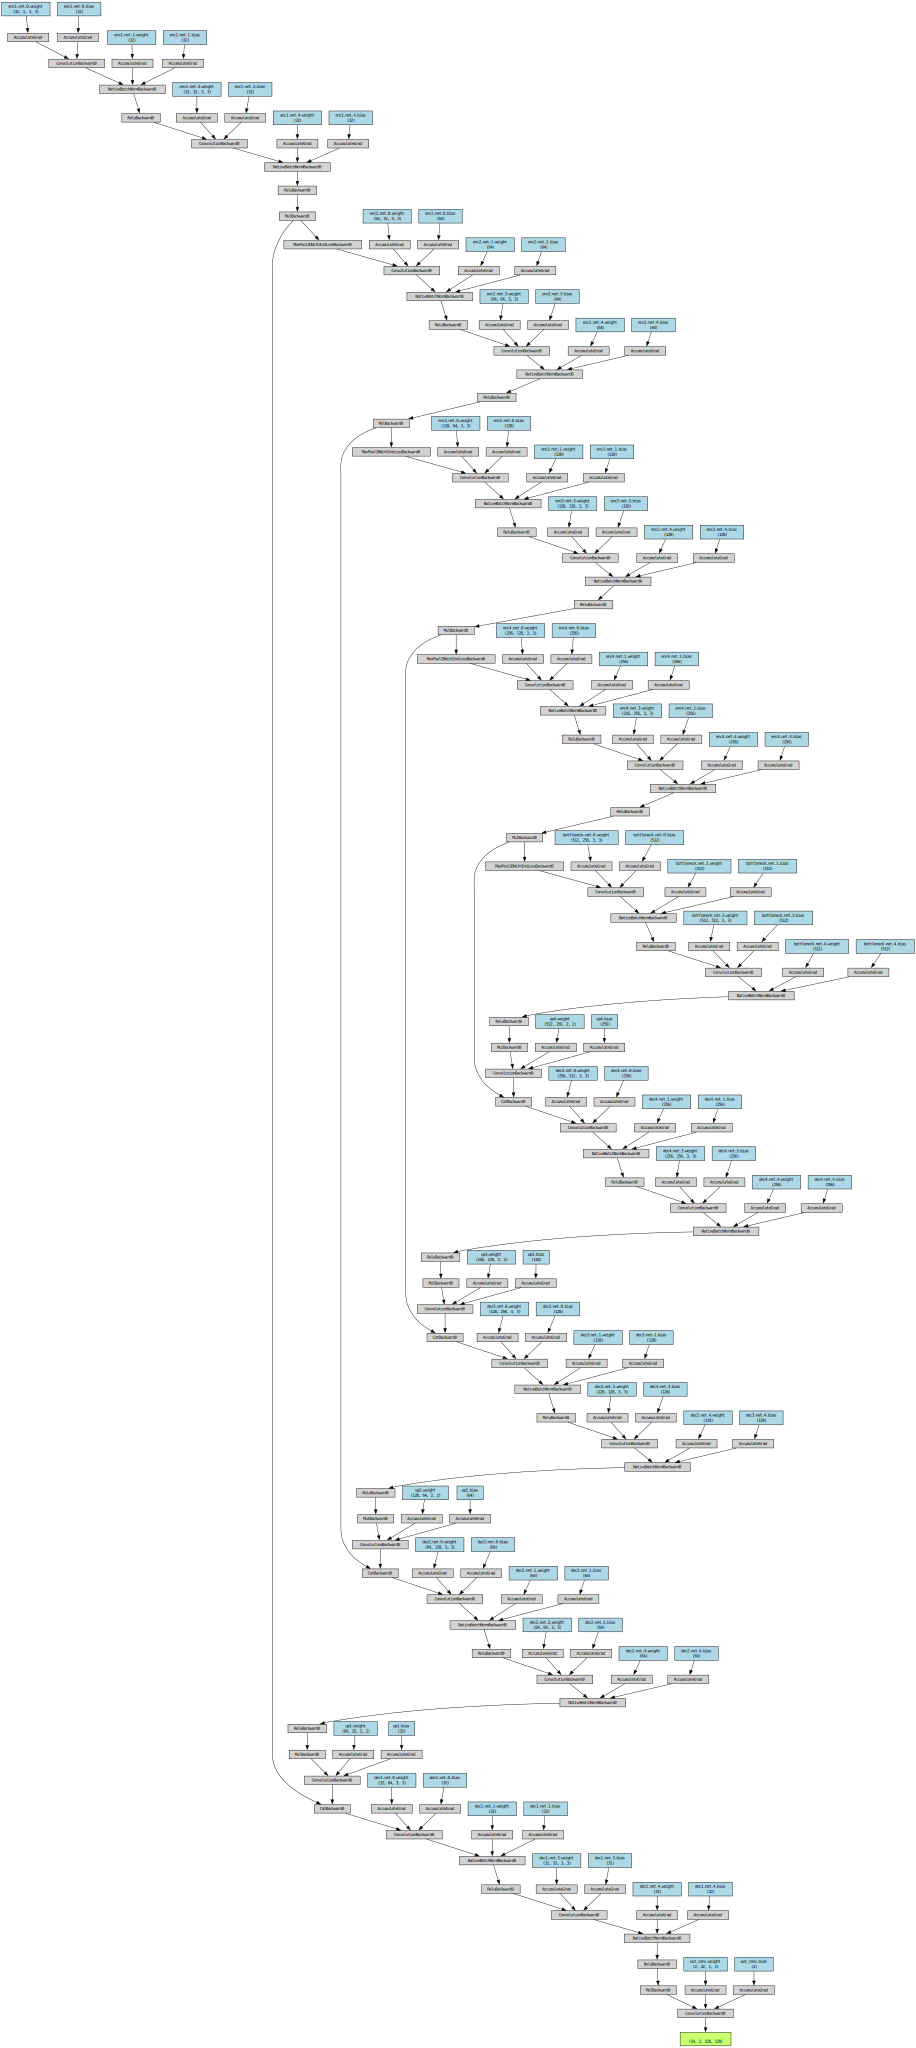

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot


class DoubleConv(nn.Module):
    """
    A helper module that performs two consecutive convolutional layers,
    each followed by a non-linear activation (e.g., ReLU). Optionally applies
    normalization (BatchNorm/InstanceNorm/GroupNorm) and/or dropout.
    This design is part of the original U-Net's "encoder" and "decoder" blocks.
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        norm_type: str = None,
        dropout: float = 0.0
    ):
        """
        Args:
            in_channels  (int): Number of input channels.
            out_channels (int): Number of output channels for the convolutions.
            norm_type    (str): Type of normalization ('batch', 'instance', 'group', or None).
            dropout     (float): Dropout probability (0.0 means no dropout).
        """
        super().__init__()
        layers = []

        # First conv
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True))
        if norm_type == 'batch':
            layers.append(nn.BatchNorm2d(out_channels))
        elif norm_type == 'instance':
            layers.append(nn.InstanceNorm2d(out_channels, affine=True))
        elif norm_type == 'group':
            # e.g., group norm with 8 groups; adjust as needed
            layers.append(nn.GroupNorm(num_groups=8, num_channels=out_channels))
        layers.append(nn.ReLU(inplace=True))

        # Second conv
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True))
        if norm_type == 'batch':
            layers.append(nn.BatchNorm2d(out_channels))
        elif norm_type == 'instance':
            layers.append(nn.InstanceNorm2d(out_channels, affine=True))
        elif norm_type == 'group':
            layers.append(nn.GroupNorm(num_groups=8, num_channels=out_channels))
        layers.append(nn.ReLU(inplace=True))

        # Optional dropout
        if dropout > 0.0:
            layers.append(nn.Dropout(p=dropout))

        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class UNet(nn.Module):
    """
    An implementation of the U-Net architecture for 2D image segmentation,
    with optional normalization and dropout layers.

    The U-Net works as follows:
    1) Contracting path (Encoder): Repeated applications of two 3x3 convolutions, each
       followed by a non-linear activation (ReLU), then a 2x2 max pooling downsampling.
    2) Bottleneck.
    3) Expansive path (Decoder): Each step upsamples via a transposed convolution,
       concatenates the corresponding encoder feature map (skip connection), and
       applies the DoubleConv block again.
    4) A final 1x1 convolution maps features to the desired number of classes.

    Args:
        in_channels  (int): Number of channels in the input image.
        out_channels (int): Number of output segmentation classes.
        base_filters (int): Number of filters in the first encoder block.
        norm_type    (str): Normalization method ('batch', 'instance', 'group', or None).
        dropout      (float): Dropout probability for each DoubleConv (0.0 = no dropout).
    """
    def __init__(
        self,
        in_channels: int = 1,
        out_channels: int = 2,
        base_filters: int = 64,
        norm_type: str = None,
        dropout: float = 0.0
    ):
        super().__init__()

        # === Encoder ===
        self.enc1 = DoubleConv(in_channels, base_filters, norm_type=norm_type, dropout=dropout)
        self.enc2 = DoubleConv(base_filters, base_filters * 2, norm_type=norm_type, dropout=dropout)
        self.enc3 = DoubleConv(base_filters * 2, base_filters * 4, norm_type=norm_type, dropout=dropout)
        self.enc4 = DoubleConv(base_filters * 4, base_filters * 8, norm_type=norm_type, dropout=dropout)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # === Bottleneck ===
        self.bottleneck = DoubleConv(base_filters * 8, base_filters * 16, norm_type=norm_type, dropout=dropout)

        # === Decoder ===
        self.up4 = nn.ConvTranspose2d(base_filters * 16, base_filters * 8, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(base_filters * 16, base_filters * 8, norm_type=norm_type, dropout=dropout)

        self.up3 = nn.ConvTranspose2d(base_filters * 8, base_filters * 4, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(base_filters * 8, base_filters * 4, norm_type=norm_type, dropout=dropout)

        self.up2 = nn.ConvTranspose2d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(base_filters * 4, base_filters * 2, norm_type=norm_type, dropout=dropout)

        self.up1 = nn.ConvTranspose2d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(base_filters * 2, base_filters, norm_type=norm_type, dropout=dropout)

        self.out_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Encoder (downsampling path)
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder (upsampling path)
        d4 = self.up4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)
        return out


if __name__ == "__main__":
    # Example usage and visualization of the network

    # Instantiate the model
    model = UNet(in_channels=1, out_channels=2, base_filters=32, norm_type='batch', dropout=0.1)
    print(model)

    # Create a dummy input tensor for testing
    dummy_input = torch.randn(10, 1, 128, 128)  # (batch_size, channels, height, width)

    # Forward pass
    output = model(dummy_input)
    print(f"Output shape: {output.shape}")

    dot = make_dot(output, params=dict(model.named_parameters()))
    dot.render("unet_architecture", format="png")
    display(dot)



## Step 6: Training the model

Loss and Evaluation Metrics

1. **Cross-Entropy Loss (CE)**  
   $$
   L_{\text{CE}} = -\frac{1}{N} \sum_{i=1}^N \sum_{c=1}^C y_{i, c} \log \bigl(\hat{p}_{i, c}\bigr)
   $$  
   Here, \( N \) is the number of samples, \( C \) is the number of classes, \( y_{i,c} \) is 1 if the \( i\)-th sample belongs to class \(c\) and 0 otherwise, and \(\hat{p}_{i,c}\) is the predicted probability of the \( i\)-th sample for class \(c\).

2. **Dice Similarity Coefficient (DSC)**  
   $$
   \text{DSC}(A, B) = \frac{2 |A \cap B|}{|A| + |B|}
   $$  
   In segmentation, \( A \) represents the set of predicted positive pixels/voxels, and \( B \) the set of ground-truth positive pixels/voxels. The Dice score ranges from 0 (no overlap) to 1 (perfect overlap).

These are frequently used in medical image segmentation to train and evaluate models. The cross-entropy (CE) loss is a standard choice for multi-class classification, while the Dice coefficient (or a Dice-based loss) is widely used in scenarios with heavy class imbalance, as it directly measures set overlap between prediction and ground truth.


Total images found: 484
Total labels found: 484
Train set size: 100
Val set size: 20
Example training image: Task01_BrainTumour/imagesTr/BRATS_194.nii.gz
Example training mask: Task01_BrainTumour/labelsTr/BRATS_194.nii.gz
Using MPS on Apple Silicon!


Val Epoch 1/40: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]



Epoch [1/40] - Train Loss: 1.2268, Train DSC: 0.3851 | Val Loss: 0.9817, Val DSC: 0.4466


Val Epoch 2/40: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]



Epoch [2/40] - Train Loss: 0.4386, Train DSC: 0.4161 | Val Loss: 0.1829, Val DSC: 0.4466


Val Epoch 3/40: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it]



Epoch [3/40] - Train Loss: 0.1602, Train DSC: 0.4186 | Val Loss: 0.1217, Val DSC: 0.4466


Val Epoch 4/40: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]



Epoch [4/40] - Train Loss: 0.1272, Train DSC: 0.4161 | Val Loss: 0.1041, Val DSC: 0.4466


Val Epoch 5/40: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]



Epoch [5/40] - Train Loss: 0.1100, Train DSC: 0.4161 | Val Loss: 0.0957, Val DSC: 0.4466
Saved checkpoint: checkpoints_brain_tumor/unet_epoch5.pth


Val Epoch 6/40: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]



Epoch [6/40] - Train Loss: 0.0967, Train DSC: 0.4161 | Val Loss: 0.0801, Val DSC: 0.4466


Val Epoch 7/40: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]



Epoch [7/40] - Train Loss: 0.0861, Train DSC: 0.4161 | Val Loss: 0.0851, Val DSC: 0.4466


Val Epoch 8/40: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]



Epoch [8/40] - Train Loss: 0.0909, Train DSC: 0.4161 | Val Loss: 0.0681, Val DSC: 0.4466


Val Epoch 9/40: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]



Epoch [9/40] - Train Loss: 0.0815, Train DSC: 0.4161 | Val Loss: 0.0691, Val DSC: 0.4466


Val Epoch 10/40: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]



Epoch [10/40] - Train Loss: 0.0778, Train DSC: 0.4258 | Val Loss: 0.0736, Val DSC: 0.4988
Saved checkpoint: checkpoints_brain_tumor/unet_epoch10.pth


Val Epoch 11/40: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]



Epoch [11/40] - Train Loss: 0.0762, Train DSC: 0.4767 | Val Loss: 0.0686, Val DSC: 0.5218


Val Epoch 12/40: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]



Epoch [12/40] - Train Loss: 0.0734, Train DSC: 0.4986 | Val Loss: 0.0626, Val DSC: 0.5226


Val Epoch 13/40: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]



Epoch [13/40] - Train Loss: 0.0764, Train DSC: 0.5069 | Val Loss: 0.0600, Val DSC: 0.5314


Val Epoch 14/40: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]



Epoch [14/40] - Train Loss: 0.0727, Train DSC: 0.5118 | Val Loss: 0.0678, Val DSC: 0.5405


Val Epoch 15/40: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]



Epoch [15/40] - Train Loss: 0.0712, Train DSC: 0.5098 | Val Loss: 0.0547, Val DSC: 0.5449
Saved checkpoint: checkpoints_brain_tumor/unet_epoch15.pth


Val Epoch 16/40: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]



Epoch [16/40] - Train Loss: 0.0649, Train DSC: 0.5173 | Val Loss: 0.0538, Val DSC: 0.5477


Val Epoch 17/40: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]



Epoch [17/40] - Train Loss: 0.0692, Train DSC: 0.5131 | Val Loss: 0.0549, Val DSC: 0.5491


Val Epoch 18/40: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]



Epoch [18/40] - Train Loss: 0.0657, Train DSC: 0.5224 | Val Loss: 0.0592, Val DSC: 0.5807


Val Epoch 19/40: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]



Epoch [19/40] - Train Loss: 0.0689, Train DSC: 0.5292 | Val Loss: 0.0492, Val DSC: 0.5507


Val Epoch 20/40: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]



Epoch [20/40] - Train Loss: 0.0689, Train DSC: 0.5264 | Val Loss: 0.0575, Val DSC: 0.5260
Saved checkpoint: checkpoints_brain_tumor/unet_epoch20.pth


Val Epoch 21/40: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]



Epoch [21/40] - Train Loss: 0.0644, Train DSC: 0.5310 | Val Loss: 0.0538, Val DSC: 0.5636


Val Epoch 22/40: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]



Epoch [22/40] - Train Loss: 0.0600, Train DSC: 0.5485 | Val Loss: 0.0492, Val DSC: 0.5708


Val Epoch 23/40: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]



Epoch [23/40] - Train Loss: 0.0626, Train DSC: 0.5506 | Val Loss: 0.0606, Val DSC: 0.5925


Val Epoch 24/40: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]



Epoch [24/40] - Train Loss: 0.0617, Train DSC: 0.5512 | Val Loss: 0.0508, Val DSC: 0.5734


Val Epoch 25/40: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]



Epoch [25/40] - Train Loss: 0.0572, Train DSC: 0.5529 | Val Loss: 0.0563, Val DSC: 0.5224
Saved checkpoint: checkpoints_brain_tumor/unet_epoch25.pth


Val Epoch 26/40: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]



Epoch [26/40] - Train Loss: 0.0641, Train DSC: 0.5392 | Val Loss: 0.0459, Val DSC: 0.5976


Val Epoch 27/40: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]



Epoch [27/40] - Train Loss: 0.0624, Train DSC: 0.5586 | Val Loss: 0.0477, Val DSC: 0.5553


Val Epoch 28/40: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]



Epoch [28/40] - Train Loss: 0.0578, Train DSC: 0.5571 | Val Loss: 0.0477, Val DSC: 0.6146


Val Epoch 29/40: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]



Epoch [29/40] - Train Loss: 0.0586, Train DSC: 0.5794 | Val Loss: 0.0472, Val DSC: 0.5424


Val Epoch 30/40: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]



Epoch [30/40] - Train Loss: 0.0586, Train DSC: 0.5503 | Val Loss: 0.0423, Val DSC: 0.6093
Saved checkpoint: checkpoints_brain_tumor/unet_epoch30.pth


Val Epoch 31/40: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]



Epoch [31/40] - Train Loss: 0.0566, Train DSC: 0.5795 | Val Loss: 0.0451, Val DSC: 0.5805


Val Epoch 32/40: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]



Epoch [32/40] - Train Loss: 0.0519, Train DSC: 0.5749 | Val Loss: 0.0420, Val DSC: 0.5791


Val Epoch 33/40: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]



Epoch [33/40] - Train Loss: 0.0500, Train DSC: 0.5893 | Val Loss: 0.0395, Val DSC: 0.6191


Val Epoch 34/40: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]



Epoch [34/40] - Train Loss: 0.0506, Train DSC: 0.5799 | Val Loss: 0.0408, Val DSC: 0.5980


Val Epoch 35/40: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]



Epoch [35/40] - Train Loss: 0.0559, Train DSC: 0.5869 | Val Loss: 0.0553, Val DSC: 0.5515
Saved checkpoint: checkpoints_brain_tumor/unet_epoch35.pth


Val Epoch 36/40: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]



Epoch [36/40] - Train Loss: 0.0612, Train DSC: 0.5797 | Val Loss: 0.0478, Val DSC: 0.6430


Val Epoch 37/40: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]



Epoch [37/40] - Train Loss: 0.0496, Train DSC: 0.6015 | Val Loss: 0.0398, Val DSC: 0.6651


Val Epoch 38/40: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]



Epoch [38/40] - Train Loss: 0.0485, Train DSC: 0.6127 | Val Loss: 0.0360, Val DSC: 0.6554


Val Epoch 39/40: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]



Epoch [39/40] - Train Loss: 0.0490, Train DSC: 0.6029 | Val Loss: 0.0433, Val DSC: 0.6748


Val Epoch 40/40: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]



Epoch [40/40] - Train Loss: 0.0482, Train DSC: 0.6250 | Val Loss: 0.0345, Val DSC: 0.6948
Saved checkpoint: checkpoints_brain_tumor/unet_epoch40.pth


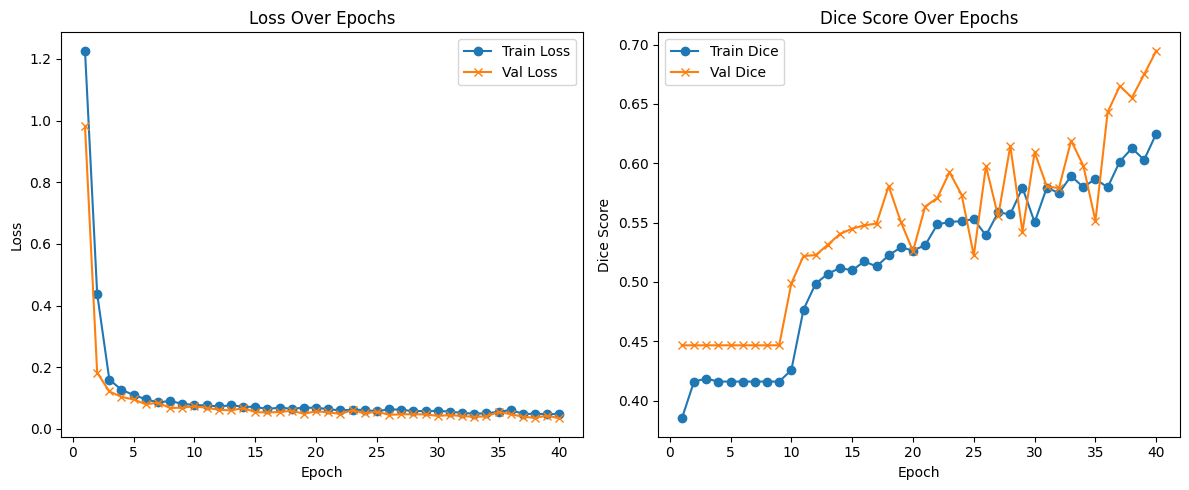

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# --------------------------------------
# 1. Define Your Loss & Metrics
# --------------------------------------
criterion = nn.CrossEntropyLoss()

def dice_coefficient(pred, target, smooth=1e-6):
    """
    Computes the Dice Coefficient for 2D segmentation.
    pred:  (B, C, H, W) logits or probabilities.
    target: (B, H, W) ground-truth labels [0..C-1].
    smooth: smoothing constant for numerical stability.

    Returns a float [0, 1], higher is better.
    """
    # Convert pred to predicted classes
    # If pred is raw logits, we do argmax
    pred_classes = torch.argmax(pred, dim=1)  # (B, H, W)

    # One-hot encode the predicted and target segmentation maps
    # so each channel corresponds to one class
    batch_size, height, width = pred_classes.shape
    num_classes = pred.shape[1]
    pred_one_hot = torch.zeros((batch_size, num_classes, height, width), device=pred.device)
    target_one_hot = torch.zeros((batch_size, num_classes, height, width), device=target.device)

    pred_one_hot.scatter_(1, pred_classes.unsqueeze(1), 1) # scatter_(dim, index, value) assigns value to the specified index along the given dim.
    # pred_classes.unsqueeze(1) reshapes the class index tensor to (B, 1, H, W), so it can be used as an index for one-hot encoding.
    target_one_hot.scatter_(1, target.unsqueeze(1), 1)

    # Compute Dice for each class, then average
    intersection = (pred_one_hot * target_one_hot).sum(dim=(2, 3))
    union = pred_one_hot.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    dice_per_class = (2.0 * intersection + smooth) / (union + smooth)
    # Average across classes, then across batch
    return dice_per_class.mean()

# --------------------------------------
# 2. Training / Validation Loop
# --------------------------------------
def train_segmentation_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=20,
    checkpoint_dir='checkpoints',
    checkpoint_freq=5
):
    """
    Trains a segmentation model with the given DataLoaders (train/val),
    optimizer, and device. Monitors both train and validation loss, as well
    as the Dice score over epochs. Saves checkpoints every 'checkpoint_freq' epochs.

    Args:
        model (nn.Module): The segmentation model (e.g., U-Net).
        train_loader (DataLoader): Training dataloader.
        val_loader   (DataLoader): Validation dataloader.
        optimizer (torch.optim.Optimizer): Optimizer (e.g., Adam).
        device (torch.device): 'cuda' or 'cpu'.
        num_epochs (int): Number of epochs to train.
        checkpoint_dir (str): Directory to save model checkpoints.
        checkpoint_freq (int): Frequency (in epochs) to save checkpoints.

    Returns:
        history (dict): Contains lists of train_loss, val_loss, train_dice, val_dice for plotting.
    """
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_dice": [],
        "val_dice": []
    }


    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        running_train_dice = 0.0

        # === Training Epoch ===
        for images, masks in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            masks = masks.to(device)  # shape (B, 1, H, W)

            outputs = model(images)    # shape (B, num_classes, H, W)
            loss = criterion(outputs, masks.squeeze(1))  # CrossEntropyLoss

            optimizer.zero_grad() # PyTorch accumulates gradients by default.
            # Without zero_grad(), gradients from previous iterations would be added to the new ones.
            loss.backward()
            optimizer.step()

            # Accumulate metrics
            running_train_loss += loss.item() # loss.item() is used to extract the scalar value from a tensor.
            # The loss variable is a PyTorch tensor, which includes computational graph information required for backpropagation.
            running_train_dice += dice_coefficient(outputs, masks.squeeze(1)).item()

        train_loss = running_train_loss / len(train_loader)
        train_dice = running_train_dice / len(train_loader)

        # === Validation Epoch ===
        model.eval()
        running_val_loss = 0.0
        running_val_dice = 0.0

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Val Epoch {epoch+1}/{num_epochs}"):
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                val_loss = criterion(outputs, masks.squeeze(1))

                running_val_loss += val_loss.item()
                running_val_dice += dice_coefficient(outputs, masks.squeeze(1)).item()

        val_loss = running_val_loss / len(val_loader)
        val_dice = running_val_dice / len(val_loader)

        # === Logging & Checkpoints ===
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_dice"].append(train_dice)
        history["val_dice"].append(val_dice)

        print(f"\nEpoch [{epoch+1}/{num_epochs}]"
              f" - Train Loss: {train_loss:.4f}, Train DSC: {train_dice:.4f}"
              f" | Val Loss: {val_loss:.4f}, Val DSC: {val_dice:.4f}")

        # Save checkpoint periodically
        if (epoch + 1) % checkpoint_freq == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"unet_epoch{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")

    return history

# --------------------------------------
# 3. Putting It All Together: Example
# --------------------------------------
if __name__ == "__main__":

    # -------------------------------------------------------------
    # 1. Randomly Select 100 Training + 20 Validation Subjects
    # -------------------------------------------------------------

    image_dir = "Task01_BrainTumour/imagesTr"
    label_dir = "Task01_BrainTumour/labelsTr"

    # Collect all file paths
    all_image_paths = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
    all_label_paths = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))

    print(f"Total images found: {len(all_image_paths)}")
    print(f"Total labels found: {len(all_label_paths)}")

    # Zip them together for consistent shuffling
    zipped_paths = list(zip(all_image_paths, all_label_paths))

    # Shuffle them to get a random subset
    random.shuffle(zipped_paths)

    # For this example, we want 100 images for training, 20 for validation
    num_train = 100
    num_val = 20
    subset = zipped_paths[: (num_train + num_val)]

    train_zipped = subset[:num_train]  # first 100
    val_zipped = subset[num_train:]    # next 20

    train_image_paths = [p[0] for p in train_zipped]
    train_mask_paths  = [p[1] for p in train_zipped]
    val_image_paths   = [p[0] for p in val_zipped]
    val_mask_paths    = [p[1] for p in val_zipped]

    print("Train set size:", len(train_image_paths))
    print("Val set size:", len(val_image_paths))

    # Creating the datasets
    train_dataset = MedicalSegmentationDataset(train_image_paths, train_mask_paths, target_shape=(128, 128), slice_choice='middle')
    val_dataset = MedicalSegmentationDataset(val_image_paths, val_mask_paths, target_shape=(128, 128), slice_choice='middle')

    # Wrap them in DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, pin_memory=True)


    # Check for CUDA (NVIDIA GPU)
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using CUDA on {torch.cuda.get_device_name(0)}!")

    # Check for MPS (Apple Silicon)
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
        print("Using MPS on Apple Silicon!")

    # Default to CPU
    else:
        device = torch.device("cpu")
        print("No GPU available, falling back to CPU.")


    # Initialize model, optimizer, etc.
    model = UNet(in_channels=4, out_channels=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Train
    num_epochs = 40
    history = train_segmentation_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        checkpoint_dir='checkpoints_brain_tumor',
        checkpoint_freq=5
    )

    # After training loop
    fig, (ax_loss, ax_dice) = plt.subplots(1, 2, figsize=(12, 5))

    ax_loss.plot(range(1, num_epochs+1), history["train_loss"], label='Train Loss', marker='o')
    ax_loss.plot(range(1, num_epochs+1), history["val_loss"], label='Val Loss', marker='x')
    ax_loss.set_title("Loss Over Epochs")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()

    ax_dice.plot(range(1, num_epochs+1), history["train_dice"], label='Train Dice', marker='o')
    ax_dice.plot(range(1, num_epochs+1), history["val_dice"], label='Val Dice', marker='x')
    ax_dice.set_title("Dice Score Over Epochs")
    ax_dice.set_xlabel("Epoch")
    ax_dice.set_ylabel("Dice Score")
    ax_dice.legend()

    plt.tight_layout()
    plt.show()



## Step 8: Evaluation and Visualization
After training, run inference on `val_loader` and visualize a sample. Replace with real data once you have it.

/var/folders/7m/znbybd0d4dq84vh8my014q3c0000gn/T/ipykernel_63983/2360895797.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map

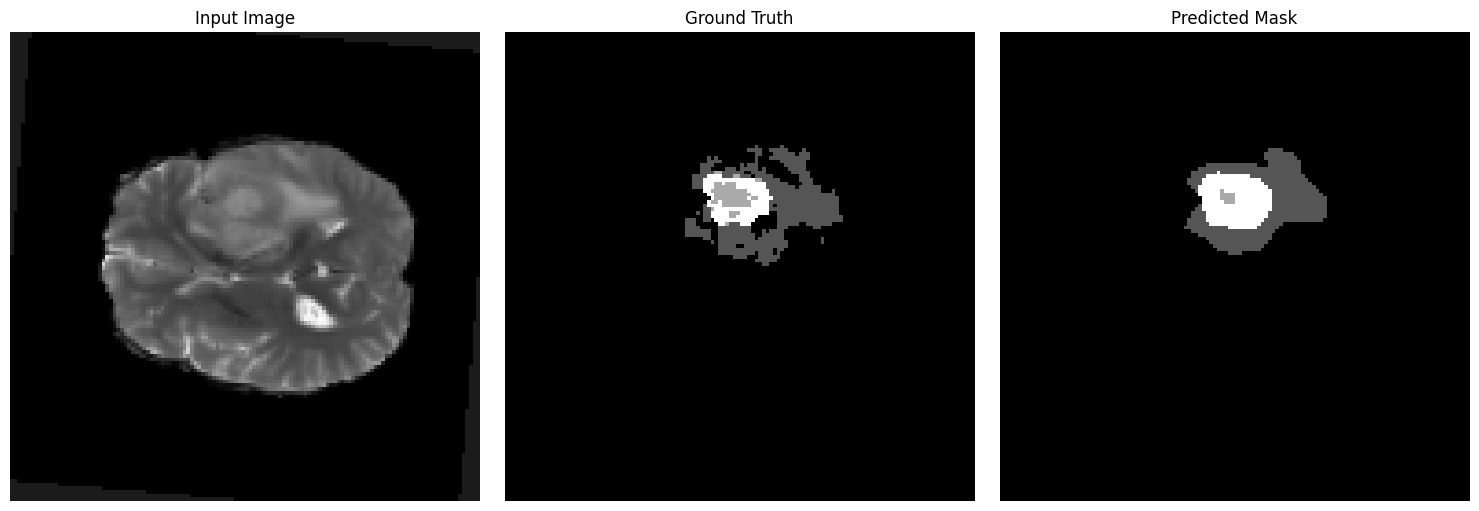

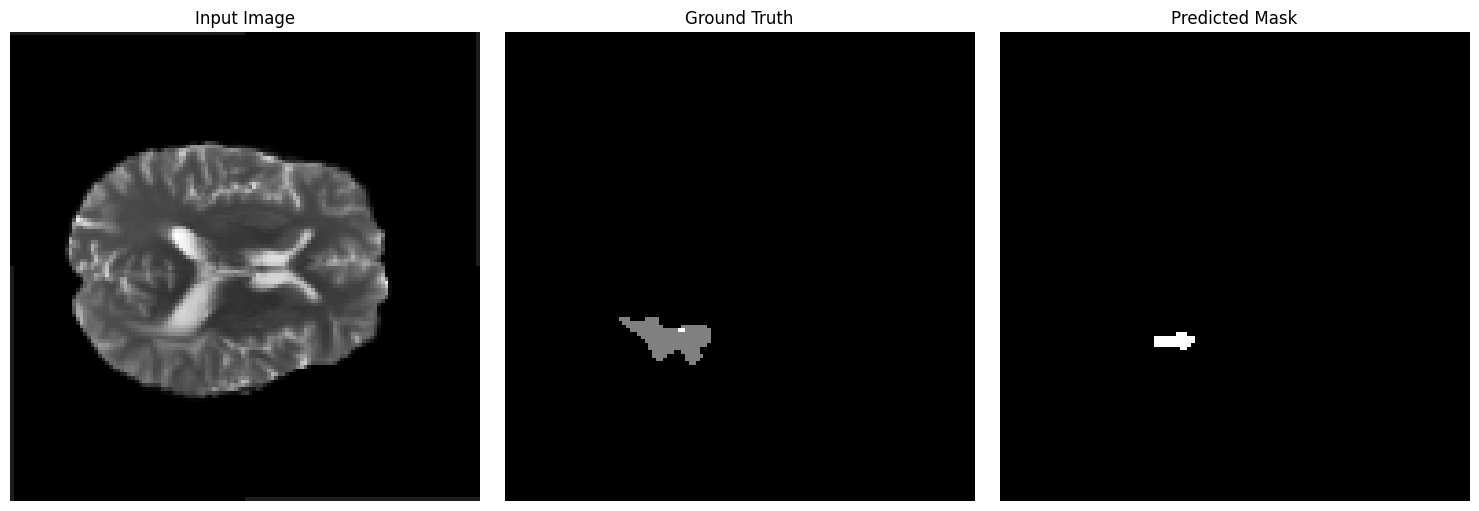

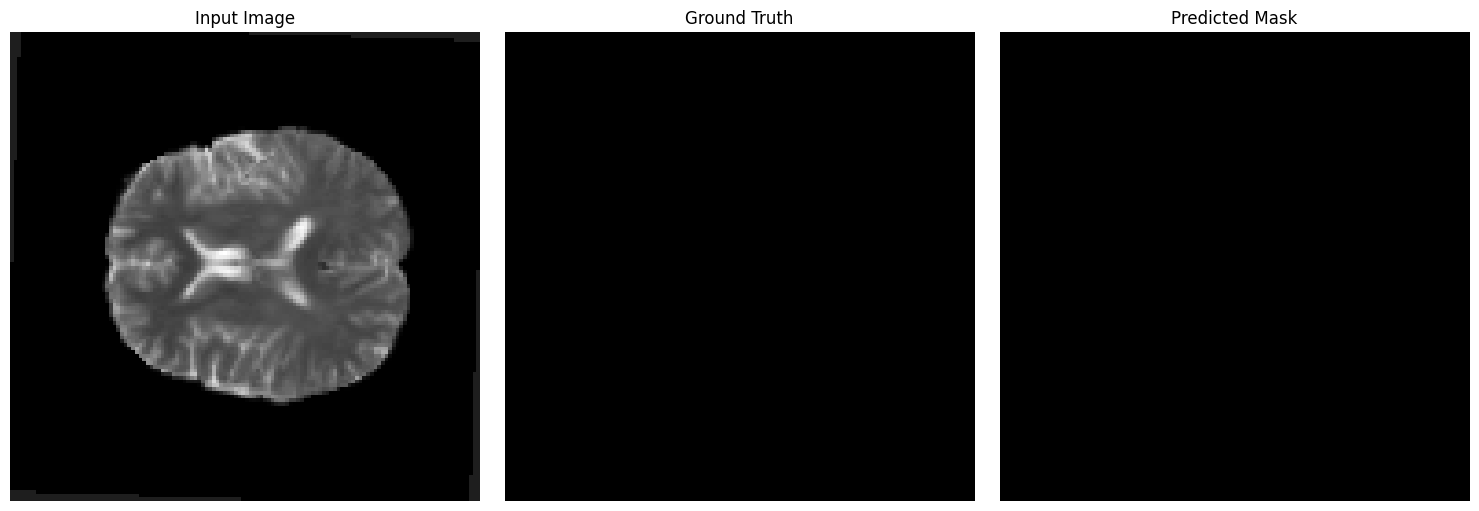

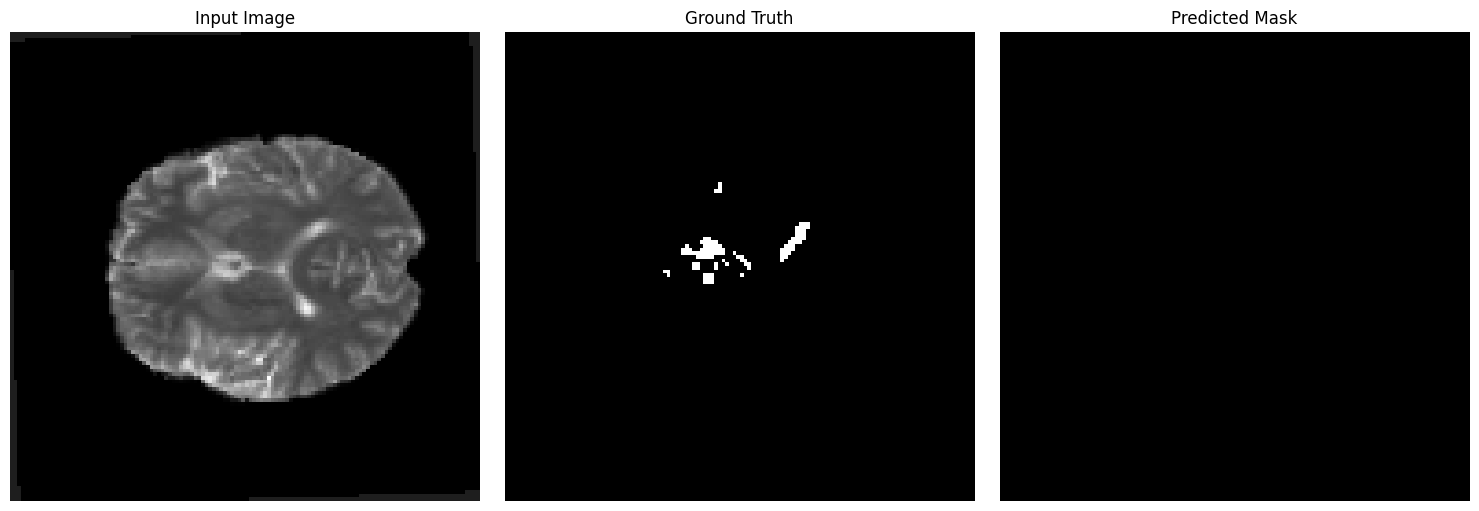

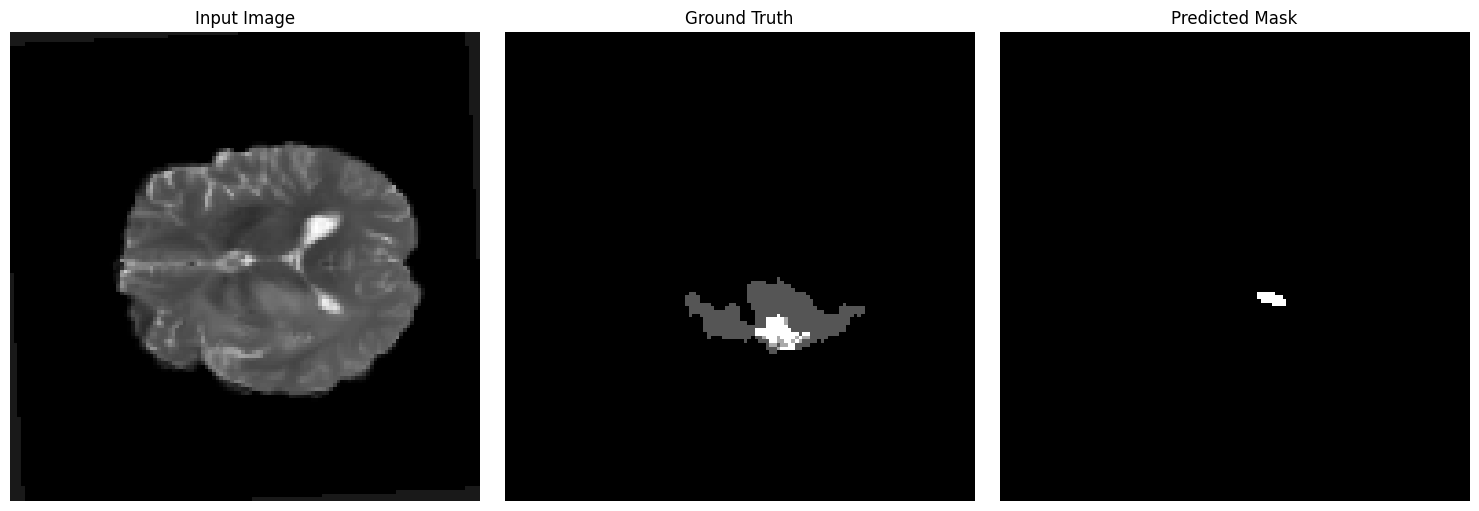

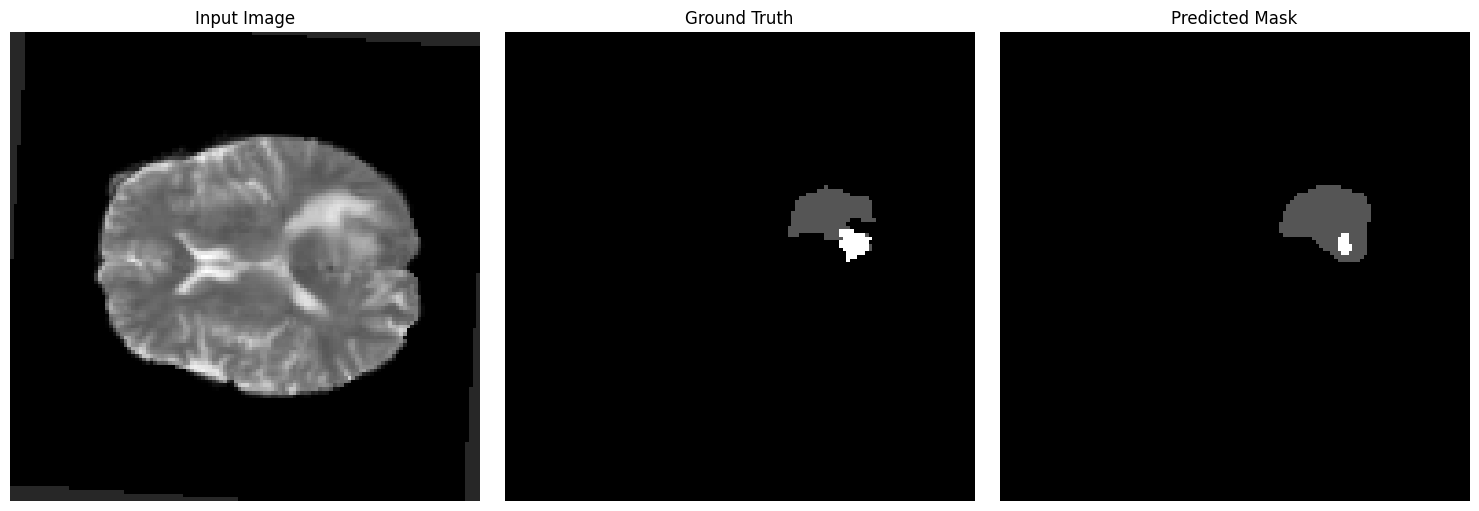

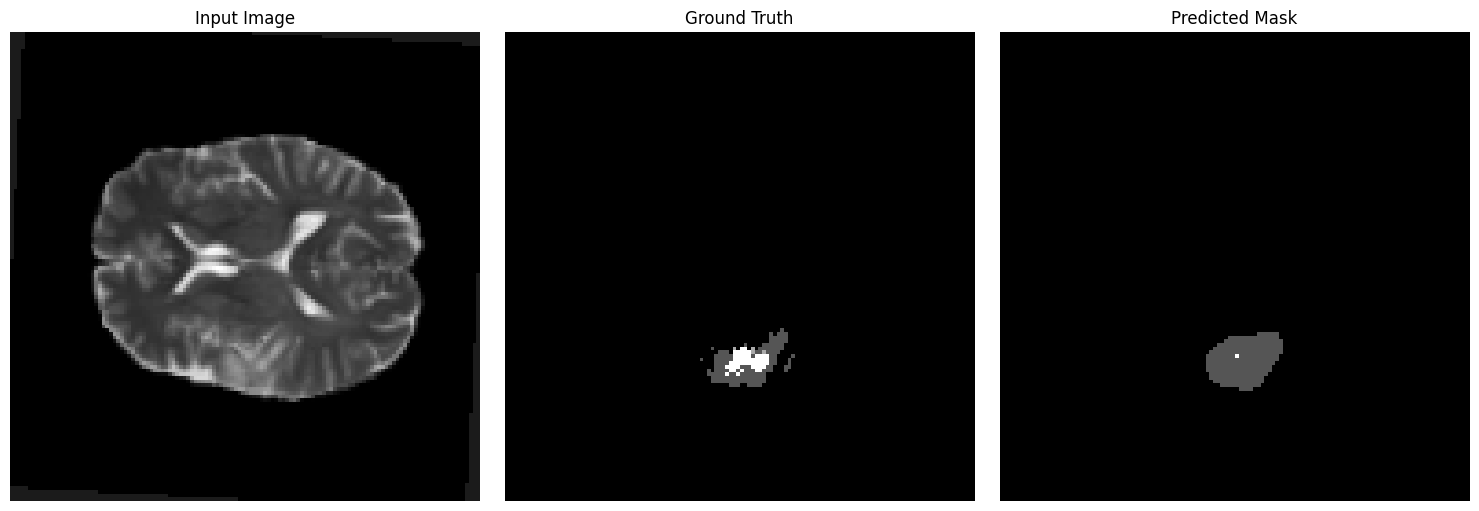

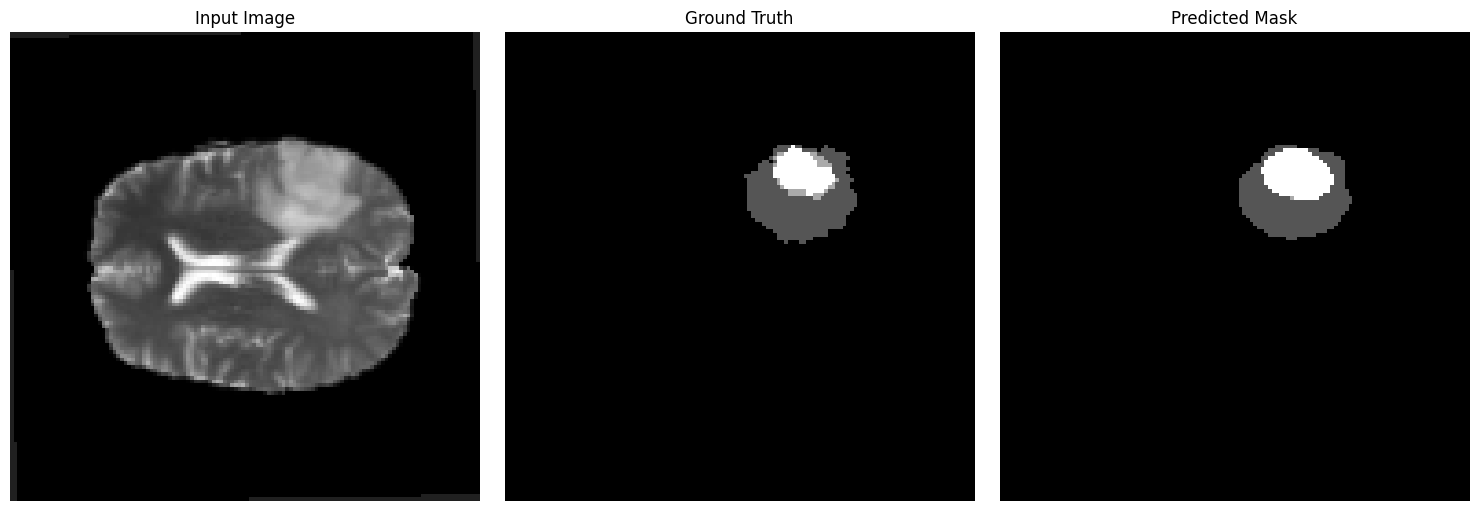

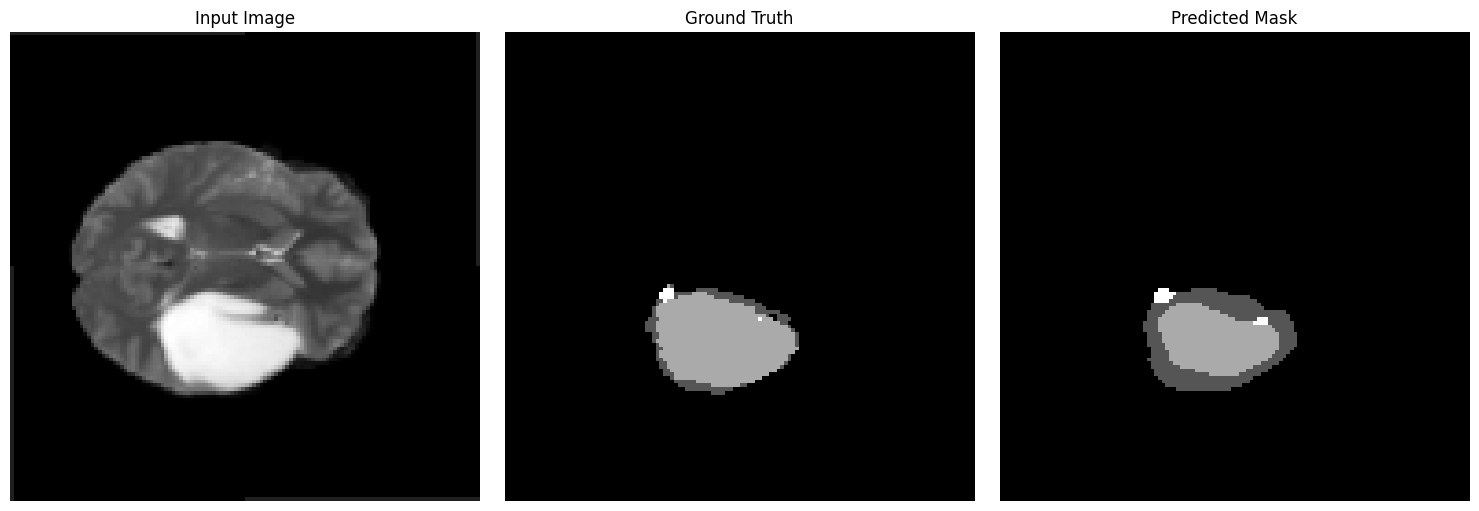

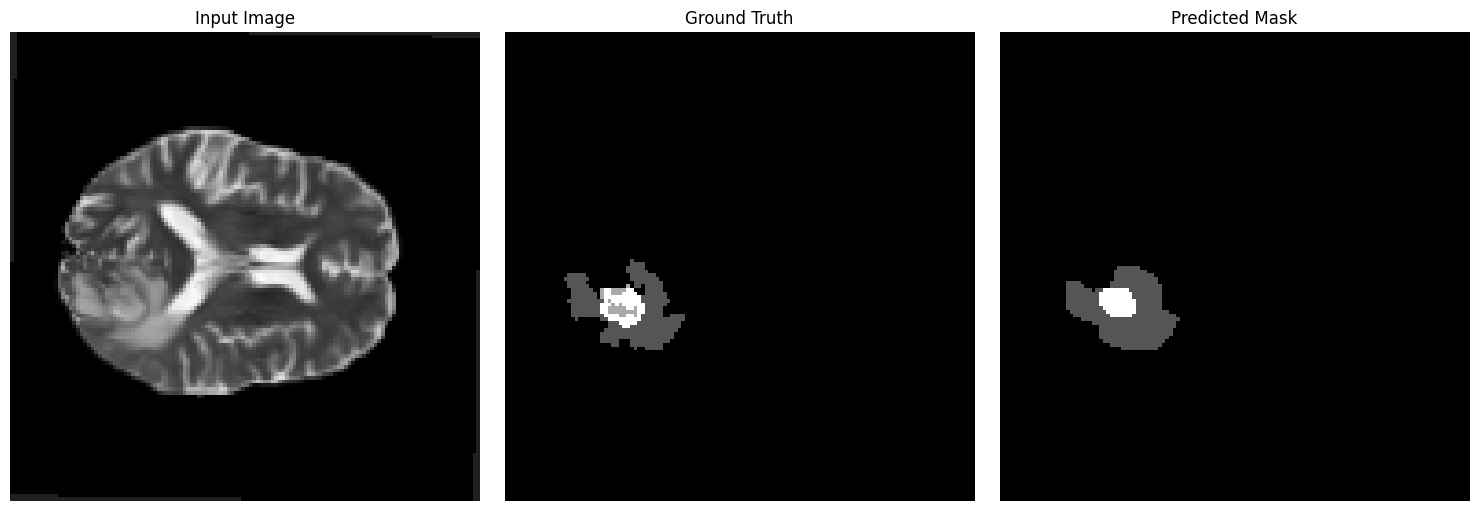

In [58]:
import matplotlib.pyplot as plt

def evaluate_segmentation(model, val_loader, device, max_examples=3):
    """
    Evaluates the trained U-Net model on a few validation samples and
    visualizes the results. This function:
      1) Puts the model in evaluation mode (model.eval()).
      2) Iterates over the validation DataLoader.
      3) Obtains predictions and converts them to class labels (argmax).
      4) Displays the input image, ground truth mask, and model prediction.

    Args:
        model (nn.Module): The trained segmentation model.
        val_loader (DataLoader): DataLoader containing validation data.
        device (torch.device): 'mps' or 'cpu' (or 'cuda' if on NVIDIA GPU).
        max_examples (int): How many examples to visualize from the validation set.
    """

    model.eval()
    examples_shown = 0

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(val_loader):
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)  # (B, num_classes, H, W)
            # Convert logits to class predictions
            preds = torch.argmax(outputs, dim=1)  # (B, H, W)
            
            # Loop over batch to visualize each sample
            for i in range(images.shape[0]):
                # Convert tensors to NumPy arrays
                img_np = images[i].cpu().numpy()
                mask_np = masks[i].cpu().numpy().squeeze()
                pred_np = preds[i].cpu().numpy().squeeze()

                # Handle multi-channel images (e.g., 4-channel MRI) by taking one channel for display
                if img_np.ndim == 3:
                    # img_np shape example: (channels, height, width)
                    # Select the first channel for grayscale visualization
                    img_np = img_np[3]  
                
                # Create a figure with 1 row, 3 columns
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))

                # Display Input Image
                axs[0].imshow(img_np, cmap='gray')
                axs[0].set_title('Input Image')
                axs[0].axis('off')

                # Display Ground Truth
                axs[1].imshow(mask_np, cmap='gray')
                axs[1].set_title('Ground Truth')
                axs[1].axis('off')

                # Display Model Prediction
                axs[2].imshow(pred_np, cmap='gray')
                axs[2].set_title('Predicted Mask')
                axs[2].axis('off')

                plt.tight_layout()
                plt.show()

                examples_shown += 1
                if examples_shown >= max_examples:
                    return  # Stop after showing 'max_examples' samples

# Example usage after training:
# 1. Initialize the same U-Net architecture used for training
model = UNet(in_channels=4, out_channels=4, base_filters=64).to(device)

# 2. Specify the checkpoint path (the model weights you saved)
checkpoint_path = "checkpoints_brain_tumor/unet_epoch40.pth"

# 3. Load the checkpoint into the model
#    Using 'map_location=device' ensures the weights go to the correct device (MPS, CPU, or CUDA).
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)

# 4. (Optionally) set model to eval mode here. 
#    It's also set to eval mode within 'evaluate_segmentation',
#    but you can do it again if you want clarity.
model.eval()

# 5. Evaluate the model on the validation set
evaluate_segmentation(model, val_loader, device, max_examples=10)



## Next Steps

1. **Hyperparameter Tuning**  
   - **Learning Rate**: Experiment with different learning rates or learning rate schedulers (e.g., cosine annealing, step-based, or exponential decay).  
   - **Batch Size**: Increasing the batch size can improve gradient estimates if you have enough GPU/memory resources. However, in medical imaging with large 3D volumes or 2D slices, memory constraints can be significant.

2. **More Refined Splits**  
   - Currently, we have a fixed train/validation split (100 training, 20 validation).   
   - Possibly explore **k-fold cross-validation** to make the most of limited medical data and reduce overfitting.

3. **Extended Data Augmentation**  
   - The current augmentations (random flips, rotations, intensity jitter) could be expanded to include **elastic deformations**, **random zoom/cropping**, or **Gaussian noise**.  
   - Advanced libraries like **Albumentations** or **MONAI** contain specialized transforms (e.g., spatial, intensity-based) tailored for medical images.

4. **Experiment with 3D Approaches**  
   - While a 2D U-Net often suffices for demonstration and proof-of-concept, 3D U-Net can leverage more contextual information from adjacent slices.  
   - Check GPU memory constraints and possibly use patch-based 3D training if full 3D volumes are too large.

5. **Use Dice Losses**  
   - **Dice Loss** is commonly used in medical imaging to handle class imbalance, especially when the lesion or organ is small compared to the entire volume.  
   - You could combine **Dice** and **Cross-Entropy** into a hybrid loss for improved robustness.

6. **Advanced Architectures**  
   - You can explore network variations like **Attention U-Net**, **U-Net++**, or **TransUNet** (transformer-based) for potentially better segmentation performance.  
   - Check resource usage (compute and memory) before deciding on a more complex architecture.

---

## Suggestions 

1. **Monitoring More Metrics**  
   - In addition to Dice and Cross-Entropy, consider **IoU (Intersection over Union)** and **Hausdorff Distance** for boundary accuracy.  
   - For multi-class tasks, track Dice scores per class (e.g., tumor core, edema, enhanced tumor region) if your dataset labels multiple sub-regions.

2. **Model Ensemble**  
   - Combine multiple trained models (e.g., via majority voting or probability averaging) for more robust predictions.  
   - Ensembling can sometimes produce more stable results, especially in challenging segmentation tasks.

3. **Automation & Reproducibility**  
   - Automate data splits, hyperparameter selection (**optuna**), and logging. Tools like **Weights & Biases** and **TensorBoard** can help track experiments.

---

## Conclusion

By following an **end-to-end** U-Net pipeline—from **data loading** and **preprocessing**, through **training/validation** and **visual evaluation**—you’ve tackled some of the most crucial steps in building a medical image segmentation system. Key highlights of your workflow include:

- **U-Net Architecture**  
  A strong baseline with skip connections to preserve spatial resolution, essential for segmentation tasks.

- **Appropriate Data Splits**  
  Creating separate training and validation sets ensures you can monitor overfitting and model generalization.

- **Essential Augmentation & Loss Tracking**  
  Augmentations mitigate overfitting by diversifying the training samples. Tracking **loss** and **Dice** (or IoU) ensures continuous performance monitoring.

- **Interactive Visualization**  
  Inspecting predictions on validation samples helps confirm that the model is learning meaningful features and not overfitting noisily.

With **further refinements** (hyperparameter tuning, advanced augmentation, 3D training, specialized losses, etc.), you can push the performance of your U-Net segmentation system to **state-of-the-art** levels for many medical imaging applications.